In [1]:
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import pandas_datareader as pdr
import scipy as sp
import scipy.stats
import seaborn as sns
import statsmodels.api as sm
from statsmodels.graphics import tsaplots

import warnings
warnings.simplefilter("ignore")
plt.style.use('ggplot')

In [2]:
def filter_dunder(any_obj):
    temp_list = dir(any_obj)
    date_obj_meth_attr = []
    for i in temp_list:
        if i[0:2] != '__':
            date_obj_meth_attr.append(i)
    date_obj_meth_attr = {'meth_attr':date_obj_meth_attr}
    return pd.DataFrame(date_obj_meth_attr)

As a reminder, if you want to find data online to explore, check here: https://github.com/public-apis/public-apis

In this tutorial, we practice Pandas data manipulation techniques, which are extremely useful for practical time series analysis. 

# <font face="gotham" color="purple">Import Data From CSV </font>

We import a data set of oil price for demonstrative purpose.

In [3]:
oil = pd.read_csv('oil.csv', na_values = 'n/a', parse_dates = ['date'], index_col = ['date'])
oil.columns = ['oil_price']
oil.head()

,oil_price
date,
2013-01-01,NaN
2013-01-02,93.14
2013-01-03,92.97
2013-01-04,93.12
2013-01-07,93.20


Check info summary, it tells time span and data type.

In [4]:
oil.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1218 entries, 2013-01-01 to 2017-08-31
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   oil_price  1175 non-null   float64
dtypes: float64(1)
memory usage: 19.0 KB


Check how many observations missing, it happens on bank holidays. 

In [5]:
oil['oil_price'].isnull().sum()

43

```.interpolate()``` is for filling the ```NaN``` with a specified method, if left empty, default is _linear filling_, for other methods check pandas <a href='https://pandas.pydata.org/docs/reference/api/pandas.Series.interpolate.html'>manual page</a>. 

A reminder that Pandas has **agglutinative language** feature, which means you can stack methods at the end of other one. You can stack ```to_frame``` at the end, which convert the data into DataFrame format in case it is not.

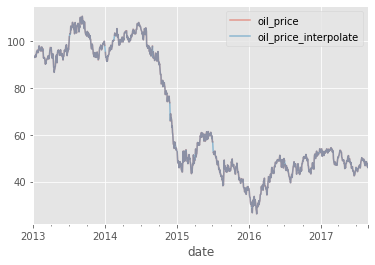

In [6]:
oil_interpolate = oil['oil_price'].interpolate().to_frame() 
oil.join(oil_interpolate.add_suffix('_interpolate')).plot(alpha=.5)
plt.show()

## <font face="gotham" color="purple">Import Data From Excel With Loop</font>

The imported file here is a summary of three stock exchanges in US, i.e. NYSE, NASDAQ, AMEX, each stock exchange takes one sheet in the spreadsheet file.

We are going to import three sheets together by a loop. 

First, instantiate an object for the Excel file, extract the sheet names.

In [7]:
xlsx_ojb = pd.ExcelFile('listings_info.xlsx')
sheetnames = xlsx_ojb.sheet_names
sheetnames

['amex', 'nasdaq', 'nyse']

In [8]:
listings = [] # each element of the list is a dataframe
for sheetname in sheetnames:
    df = pd.read_excel(xlsx_ojb, na_values='n/a', sheet_name = sheetname)
    df['Exchange'] = sheetname
    listings.append(df) # stack three exchanges' listing into df

In [9]:
listings_concat = pd.concat(listings)
listings_concat.head(5)

,Stock Symbol,Company Name,Last Sale,Market Capitalization,IPO Year,Sector,Industry,Exchange
0,XXII,"22nd Century Group, Inc",1.3300,1.206285e+08,NaN,Consumer Non-Durables,Farming/Seeds/Milling,amex
1,FAX,Aberdeen Asia-Pacific Income Fund Inc,5.0000,1.266333e+09,1986.0,NaN,NaN,amex
2,IAF,Aberdeen Australia Equity Fund Inc,6.1500,1.398653e+08,NaN,NaN,NaN,amex
3,CH,"Aberdeen Chile Fund, Inc.",7.2201,6.756346e+07,NaN,NaN,NaN,amex
4,ABE,Aberdeen Emerging Markets Smaller Company Oppo...,13.3600,1.288430e+08,NaN,NaN,NaN,amex


In [10]:
listings_concat.tail(5)

,Stock Symbol,Company Name,Last Sale,Market Capitalization,IPO Year,Sector,Industry,Exchange
3142,ZB^H,Zions Bancorporation,25.30,0.000000e+00,NaN,NaN,NaN,nyse
3143,ZBK,Zions Bancorporation,28.86,0.000000e+00,NaN,Finance,Major Banks,nyse
3144,ZOES,"Zoe&#39;s Kitchen, Inc.",17.07,3.325561e+08,2014.0,Consumer Services,Restaurants,nyse
3145,ZTS,Zoetis Inc.,53.10,2.610544e+10,2013.0,Health Care,Major Pharmaceuticals,nyse
3146,ZTO,ZTO Express (Cayman) Inc.,12.63,9.237663e+09,2016.0,Transportation,Trucking Freight/Courier Services,nyse


## <font face="gotham" color="purple">Pick The Largest Company in the Finance Sector</font>

Let's use the tickers as the index column.

In [11]:
listings_concat = listings_concat.set_index('Stock Symbol')
listings_concat.head(5)

,Company Name,Last Sale,Market Capitalization,IPO Year,Sector,Industry,Exchange
Stock Symbol,,,,,,,
XXII,"22nd Century Group, Inc",1.3300,1.206285e+08,NaN,Consumer Non-Durables,Farming/Seeds/Milling,amex
FAX,Aberdeen Asia-Pacific Income Fund Inc,5.0000,1.266333e+09,1986.0,NaN,NaN,amex
IAF,Aberdeen Australia Equity Fund Inc,6.1500,1.398653e+08,NaN,NaN,NaN,amex
CH,"Aberdeen Chile Fund, Inc.",7.2201,6.756346e+07,NaN,NaN,NaN,amex
ABE,Aberdeen Emerging Markets Smaller Company Oppo...,13.3600,1.288430e+08,NaN,NaN,NaN,amex


We can pick the tickers of top $n$ financial companies. 

This line of code is to extract the index number of top $10$ financial companies.

In [12]:
n_largest = 10
tickers_fin_larg = listings_concat.loc[listings_concat['Sector']=='Finance']['Market Capitalization'].nlargest(n_largest).index.values

Then extract the ticker names.

Retrieve data from Yahoo finance.

In [13]:
start = dt.date(2010, 1, 1)
stocks_fin_larg = pdr.data.DataReader(tickers_fin_larg, 'yahoo', start)

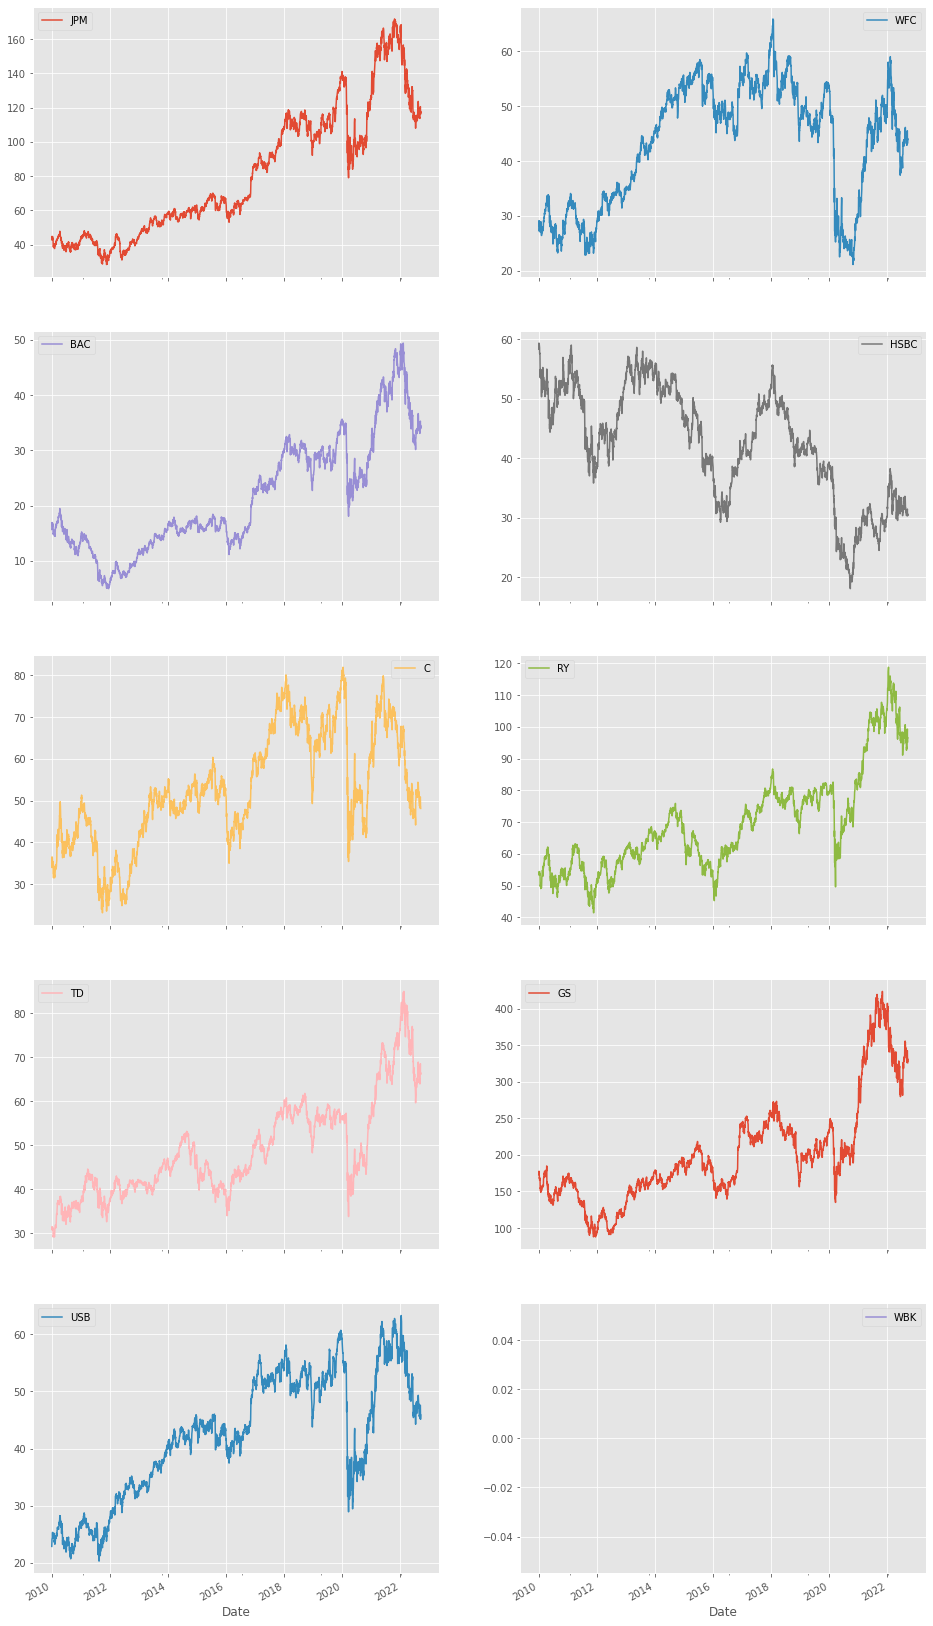

In [14]:
stocks_fin_larg['Close'].plot(subplots = True, layout = (5, 2), figsize=(16, 32)); plt.show()

If some plot not shown, it could be that Yahoo changed the ticker name.

## <font face="gotham" color="purple"> Pick The Large Major Pharmaceuticals In Health Care Sector</font>

Let's try again, pick the top pharmaceutical companies ranking from $5$ to $15$.

In [15]:
listings_health = listings_concat[listings_concat['Sector']=='Health Care']

Take a look at what industries there are in Health Care.

In [16]:
hc_type = listings_health['Industry'].unique()
hc_type # the type of health care companies

array(['Major Pharmaceuticals', 'Hospital/Nursing Management',
       'Industrial Specialties', 'Medical Specialities',
       'Biotechnology: Biological Products (No Diagnostic Substances)',
       'Medical/Dental Instruments',
       'Biotechnology: Electromedical & Electrotherapeutic Apparatus',
       'Biotechnology: Commercial Physical & Biological Resarch',
       'Biotechnology: In Vitro & In Vivo Diagnostic Substances',
       'Medical/Nursing Services', 'Medical Electronics',
       'Precision Instruments', 'Other Pharmaceuticals',
       'Ophthalmic Goods'], dtype=object)

Use ```Major Pharmaceuticals```.

In [17]:
major_pharma_ranked = listings_health[listings_health['Industry']=='Major Pharmaceuticals']['Market Capitalization'].sort_values(ascending=False)
major_pharma_picked_tickers = major_pharma_ranked[4:14].index

Again retrieve from Yahoo finance.

In [18]:
stocks_pharma_picked = pdr.data.DataReader(major_pharma_picked_tickers, 'yahoo', start)

Use only close price.

In [19]:
stocks_pharma_picked_close = stocks_pharma_picked['Close']

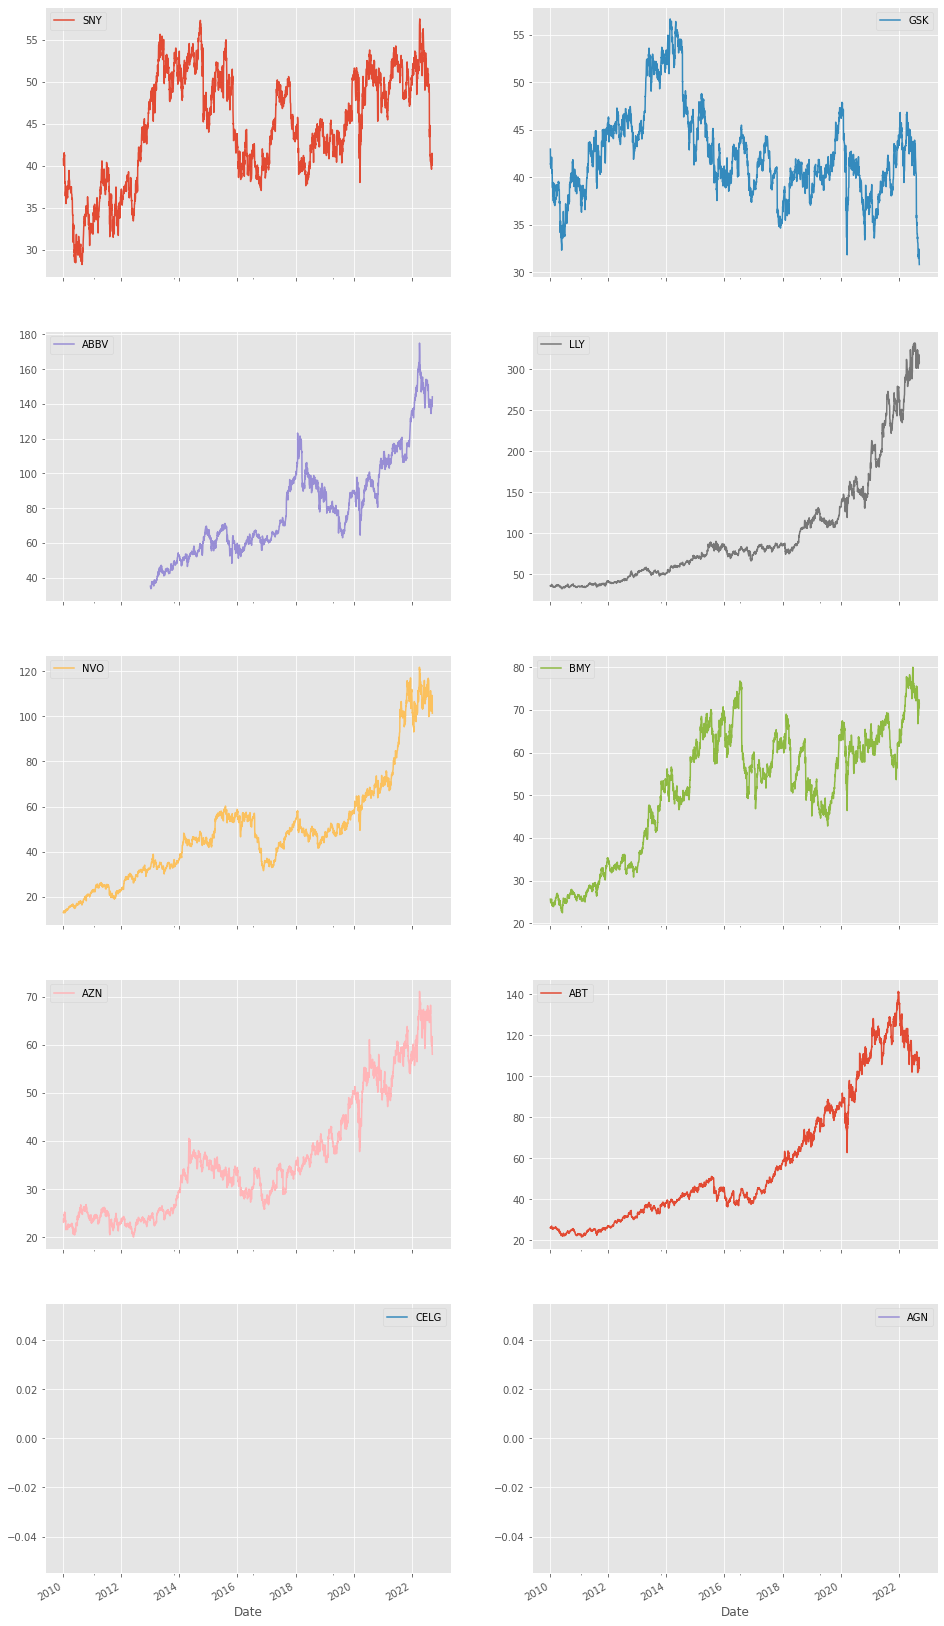

In [20]:
stocks_pharma_picked_close.plot(subplots = True, layout = (5, 2), figsize=(16, 32)); plt.show()

## <font face="gotham" color="purple"> Multiple Criteria in ```.loc``` </font>

Multiple selection criteria are joined by ```&``` sign.

In [21]:
listings_concat.loc[(listings_concat['IPO Year'] > 2008) & (listings_concat['Industry'] == 'Precious Metals')]

,Company Name,Last Sale,Market Capitalization,IPO Year,Sector,Industry,Exchange
Stock Symbol,,,,,,,
AAU,"Almaden Minerals, Ltd.",1.72,1.548917e+08,2015.0,Basic Industries,Precious Metals,amex
USAS,Americas Silver Corporation,3.05,1.206948e+08,2017.0,Basic Industries,Precious Metals,amex
PZG,Paramount Gold Nevada Corp.,1.80,3.200392e+07,2015.0,Basic Industries,Precious Metals,amex
TGD,Timmons Gold Corp,0.43,1.529203e+08,2011.0,Basic Industries,Precious Metals,amex
WRN,Western Copper and Gold Corporation,1.28,1.217160e+08,2011.0,Basic Industries,Precious Metals,amex
AGI,Alamos Gold Inc.,8.20,2.450240e+09,2015.0,Basic Industries,Precious Metals,nyse
OR,Osisko Gold Royalties Ltd,11.27,1.201307e+09,2016.0,Basic Industries,Precious Metals,nyse


## <font face="gotham" color="purple">Density Plot of Daily Returns</font>

Use the pharmaceutical data we extracted to draw distributions of daily return.

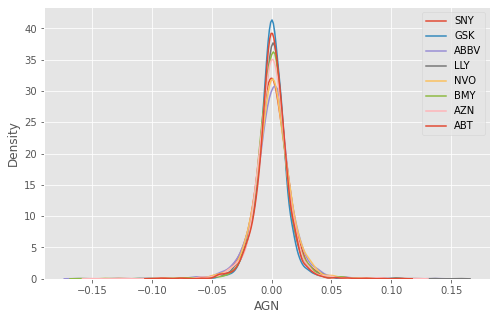

In [22]:
pharma_growth = stocks_pharma_picked_close.pct_change()
plt.figure(figsize=(8, 5))
for column in pharma_growth.columns:
    sns.distplot(pharma_growth[column], hist=False, label=column)
plt.legend()
plt.show()

## <font face="gotham" color="purple">Count Sectors</font>

Count how many companies in each sector.

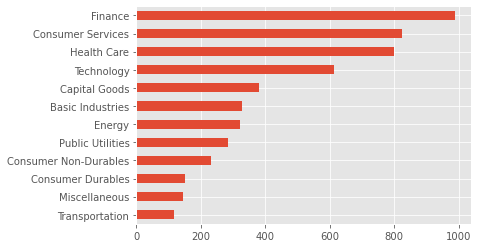

In [23]:
listings_concat['Sector'].value_counts().sort_values(ascending=True).plot(kind='barh'); plt.show()

You can count companies in industries too.

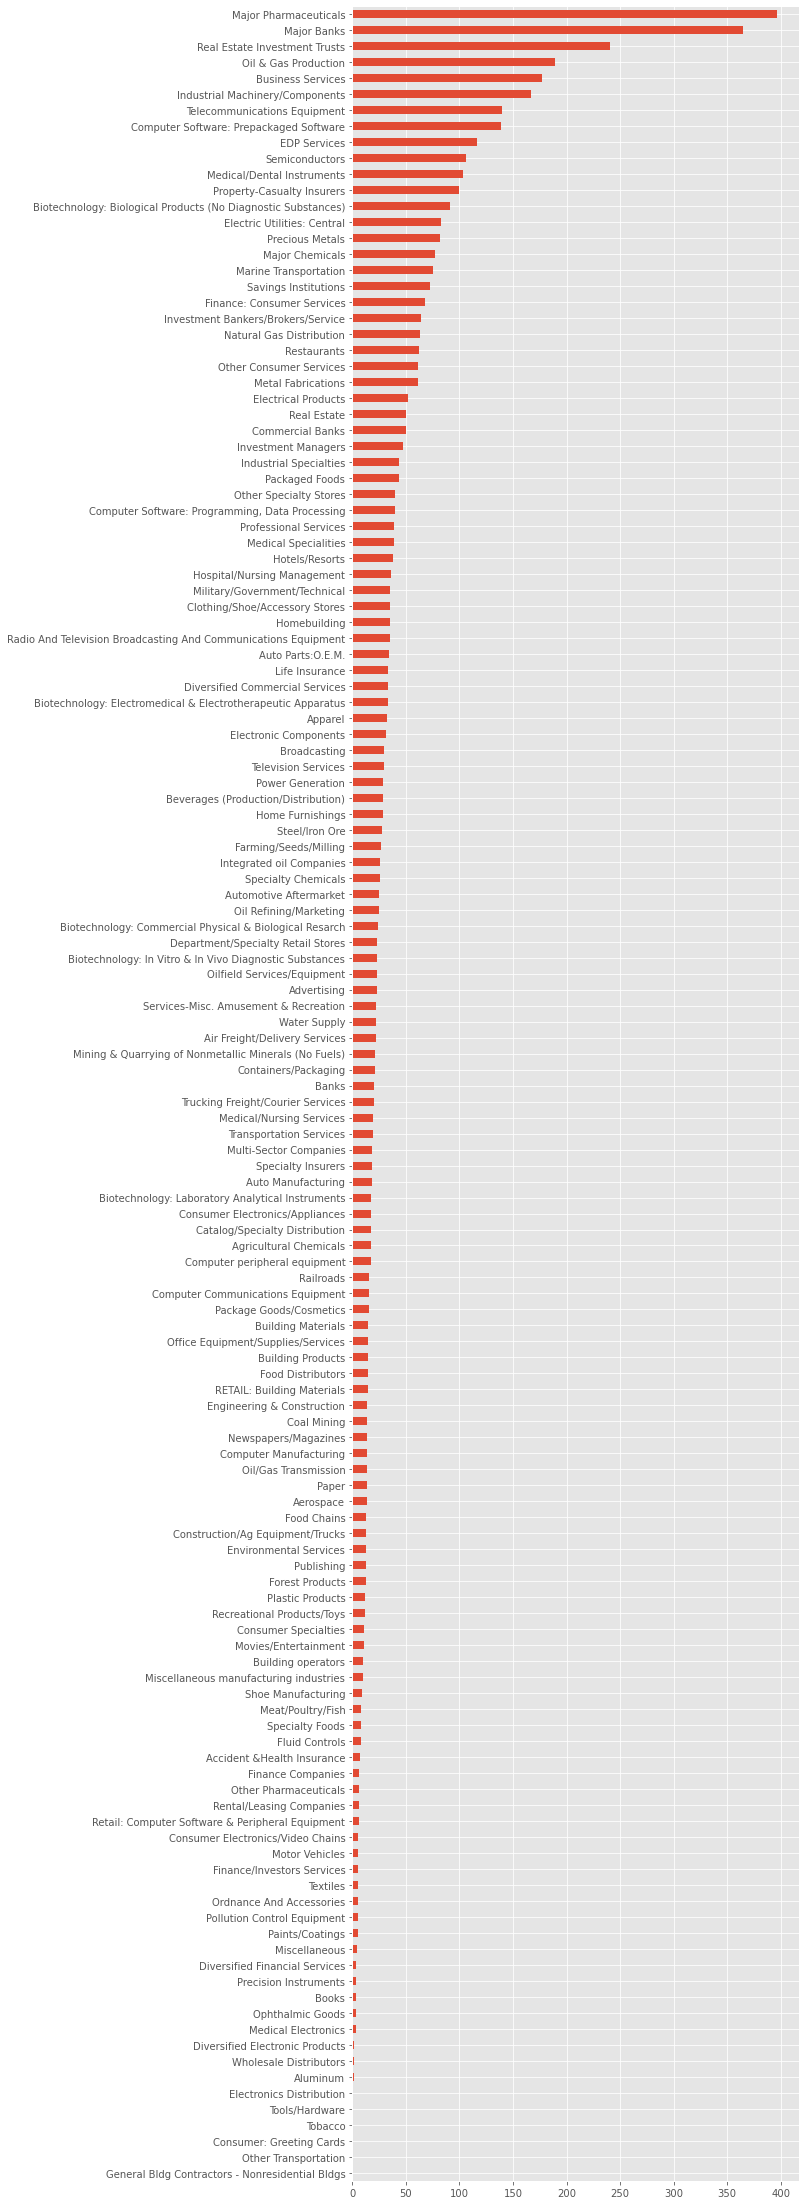

In [24]:
listings_concat['Industry'].value_counts().sort_values(ascending=True).plot(kind='barh', figsize=(8, 40)); plt.show()

## <font face="gotham" color="purple">Group By Multiple Criteria Then Unstack </font>

First we group the data by sector and exchange, then take mean of all numerical values. Of course it would be ridiculous to calculate the means of IPO year.

In [25]:
group_mean = listings_concat.groupby(['Sector', 'Exchange']).mean()
group_mean.head(21)

Last Sale  Market Capitalization     IPO Year
Sector                Exchange                                                
Basic Industries      amex        2.991475           3.916462e+08  2010.125000
                      nasdaq     21.597679           7.248999e+08  2000.766667
                      nyse       39.970990           9.590515e+09  2008.393939
Capital Goods         amex        9.677200           1.139437e+08  1998.200000
                      nasdaq     26.188681           1.511237e+09  2001.324675
                      nyse       68.115082           1.016690e+10  2006.754098
Consumer Durables     amex       24.637025           2.344459e+08          NaN
                      nasdaq     24.363391           8.398026e+08  2003.222222
                      nyse       56.791724           5.854122e+09  2006.052632
Consumer Non-Durables amex       16.491531           8.868469e+09  2006.000000
                      nasdaq     25.749565           3.104051e+09  2000.609756
                      nyse       49.625351           1.779858e+10  2007.574468
Consumer Services     amex       13.251496           2.299553e+08  2008.222222
                      nasdaq     34.917318           5.582344e+09  2004.104575
                      nyse       41.385346           6.766358e+09  2008.337500
Energy                amex        7.014829           1.090152e+09  2015.000000
                      nasdaq     15.496834           8.266076e+08  2008.034483
                      nyse       29.145299           1.291533e+10  2008.699115
Finance               amex      364.009875           7.475354e+08  1996.000000
                      nasdaq     29.644242           1.044090e+09  2010.321101
                      nyse       46.251623           1.388068e+10  2009.250000

```Unstack``` method is able to flatten the dataset by aligning the second indices, here is ```Exchange```.

In [26]:
gm_unstacked = group_mean.unstack()
gm_unstacked

Last Sale                       Market Capitalization  \
Exchange                     amex     nasdaq       nyse                  amex   
Sector                                                                          
Basic Industries         2.991475  21.597679  39.970990          3.916462e+08   
Capital Goods            9.677200  26.188681  68.115082          1.139437e+08   
Consumer Durables       24.637025  24.363391  56.791724          2.344459e+08   
Consumer Non-Durables   16.491531  25.749565  49.625351          8.868469e+09   
Consumer Services       13.251496  34.917318  41.385346          2.299553e+08   
Energy                   7.014829  15.496834  29.145299          1.090152e+09   
Finance                364.009875  29.644242  46.251623          7.475354e+08   
Health Care              3.398202  19.462531  65.695140          1.200158e+08   
Miscellaneous            5.456860  46.094369  52.180196          6.755143e+07   
Public Utilities        20.382791  18.643705  37.618231          2.676119e+09   
Technology               6.129240  31.100317  38.301812          5.955266e+07   
Transportation           5.440000  28.096758  35.243326          2.654897e+08   

                                                      IPO Year               \
Exchange                     nasdaq          nyse         amex       nasdaq   
Sector                                                                        
Basic Industries       7.248999e+08  9.590515e+09  2010.125000  2000.766667   
Capital Goods          1.511237e+09  1.016690e+10  1998.200000  2001.324675   
Consumer Durables      8.398026e+08  5.854122e+09          NaN  2003.222222   
Consumer Non-Durables  3.104051e+09  1.779858e+10  2006.000000  2000.609756   
Consumer Services      5.582344e+09  6.766358e+09  2008.222222  2004.104575   
Energy                 8.266076e+08  1.291533e+10  2015.000000  2008.034483   
Finance                1.044090e+09  1.388068e+10  1996.000000  2010.321101   
Health Care            1.758709e+09  2.856282e+10  2014.000000  2009.240409   
Miscellaneous          3.445656e+09  1.859417e+10  2017.000000  2004.333333   
Public Utilities       2.357865e+09  1.341256e+10  2011.000000  2006.040000   
Technology             1.088343e+10  9.790157e+09  2005.500000  2002.653285   
Transportation         2.869660e+09  8.491577e+09          NaN  1997.809524   

                                    
Exchange                      nyse  
Sector                              
Basic Industries       2008.393939  
Capital Goods          2006.754098  
Consumer Durables      2006.052632  
Consumer Non-Durables  2007.574468  
Consumer Services      2008.337500  
Energy                 2008.699115  
Finance                2009.250000  
Health Care            2008.883721  
Miscellaneous          2009.360000  
Public Utilities       2010.697368  
Technology             2009.833333  
Transportation         2010.162162

Select the data we care about, which is the capitalization. Compare them in the bar chart.

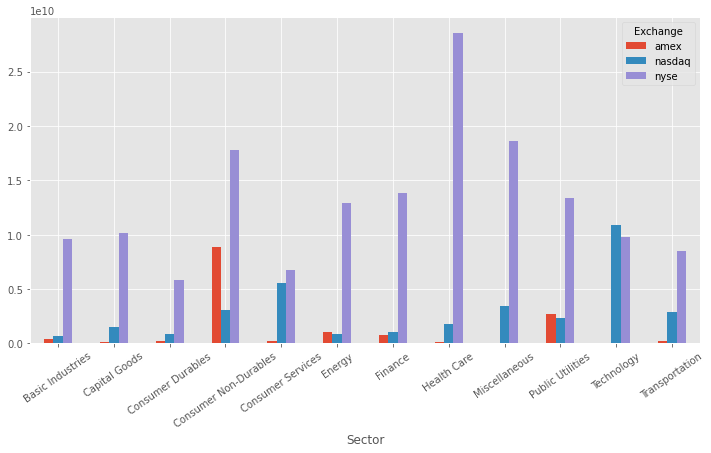

In [27]:
gm_unstacked['Market Capitalization'].plot(kind='bar', figsize=(12, 6), rot=35); plt.show()

## <font face="gotham" color="purple">Aggregate Functions</font>

Aggregate function is not particular useful, but still here we present its common use for statistical summary presentation.

In [28]:
listings_concat.groupby(['Sector', 'Exchange'])['Market Capitalization'].agg(Mean='mean', Median='median', STD='std').unstack()

Mean                                    Median  \
Exchange                       amex        nasdaq          nyse          amex   
Sector                                                                          
Basic Industries       3.916462e+08  7.248999e+08  9.590515e+09  1.485646e+08   
Capital Goods          1.139437e+08  1.511237e+09  1.016690e+10  4.959603e+07   
Consumer Durables      2.344459e+08  8.398026e+08  5.854122e+09  1.833740e+07   
Consumer Non-Durables  8.868469e+09  3.104051e+09  1.779858e+10  6.008702e+07   
Consumer Services      2.299553e+08  5.582344e+09  6.766358e+09  4.414287e+07   
Energy                 1.090152e+09  8.266076e+08  1.291533e+10  5.096386e+07   
Finance                7.475354e+08  1.044090e+09  1.388068e+10  2.386093e+08   
Health Care            1.200158e+08  1.758709e+09  2.856282e+10  4.276360e+07   
Miscellaneous          6.755143e+07  3.445656e+09  1.859417e+10  5.913104e+07   
Public Utilities       2.676119e+09  2.357865e+09  1.341256e+10  8.328349e+07   
Technology             5.955266e+07  1.088343e+10  9.790157e+09  3.968076e+07   
Transportation         2.654897e+08  2.869660e+09  8.491577e+09  2.654897e+08   

                                                            STD                \
Exchange                     nasdaq          nyse          amex        nasdaq   
Sector                                                                          
Basic Industries       1.503852e+08  2.450240e+09  6.053079e+08  1.445545e+09   
Capital Goods          2.938010e+08  3.215113e+09  1.619466e+08  4.829847e+09   
Consumer Durables      1.775939e+08  2.982585e+09  4.418130e+08  1.907605e+09   
Consumer Non-Durables  2.299307e+08  4.701718e+09  3.171573e+10  1.299809e+10   
Consumer Services      5.241519e+08  1.784206e+09  4.358058e+08  2.649225e+10   
Energy                 1.824278e+08  1.838884e+09  4.783382e+09  1.568870e+09   
Finance                2.054766e+08  2.177155e+09  1.305761e+09  2.874796e+09   
Health Care            1.738233e+08  5.879060e+09  2.271879e+08  8.767259e+09   
Miscellaneous          2.280962e+08  3.734556e+09  3.954355e+07  1.146105e+10   
Public Utilities       3.789958e+08  4.087368e+09  4.490753e+09  8.729065e+09   
Technology             6.007210e+08  2.077509e+09  4.918449e+07  6.227940e+10   
Transportation         4.797775e+08  7.982157e+08           NaN  6.915407e+09   

                                     
Exchange                       nyse  
Sector                               
Basic Industries       2.484547e+10  
Capital Goods          2.025462e+10  
Consumer Durables      8.996673e+09  
Consumer Non-Durables  3.660858e+10  
Consumer Services      1.869368e+10  
Energy                 3.668970e+10  
Finance                3.235082e+10  
Health Care            5.186314e+10  
Miscellaneous          5.000191e+10  
Public Utilities       2.913915e+10  
Technology             2.613643e+10  
Transportation         1.828119e+10

## <font face="gotham" color="purple">Countplot</font>

Let's find all companies which are listed after year $2000$.

In [29]:
listings_concat_post2000 = listings_concat[listings_concat['IPO Year']>2000]
listings_concat_post2000.head()

,Company Name,Last Sale,Market Capitalization,IPO Year,Sector,Industry,Exchange
Stock Symbol,,,,,,,
AAU,"Almaden Minerals, Ltd.",1.7200,1.548917e+08,2015.0,Basic Industries,Precious Metals,amex
USAS,Americas Silver Corporation,3.0500,1.206948e+08,2017.0,Basic Industries,Precious Metals,amex
AINC,Ashford Inc.,57.3373,1.155508e+08,2014.0,Consumer Services,Professional Services,amex
AUXO,"Auxilio, Inc.",6.3043,5.913104e+07,2017.0,Miscellaneous,Business Services,amex
BPMX,BioPharmX Corporation,0.6999,4.739693e+07,2015.0,Health Care,Major Pharmaceuticals,amex


However you can see the year type is not integers, but rather floats. Use ```.astype``` to convert the data type.

In [30]:
listings_concat_post2000['IPO Year'] = listings_concat_post2000['IPO Year'].astype(int)
listings_concat_post2000.head()

,Company Name,Last Sale,Market Capitalization,IPO Year,Sector,Industry,Exchange
Stock Symbol,,,,,,,
AAU,"Almaden Minerals, Ltd.",1.7200,1.548917e+08,2015,Basic Industries,Precious Metals,amex
USAS,Americas Silver Corporation,3.0500,1.206948e+08,2017,Basic Industries,Precious Metals,amex
AINC,Ashford Inc.,57.3373,1.155508e+08,2014,Consumer Services,Professional Services,amex
AUXO,"Auxilio, Inc.",6.3043,5.913104e+07,2017,Miscellaneous,Business Services,amex
BPMX,BioPharmX Corporation,0.6999,4.739693e+07,2015,Health Care,Major Pharmaceuticals,amex


Now we can plot the listings in each year after $2000$ in every exchanges.

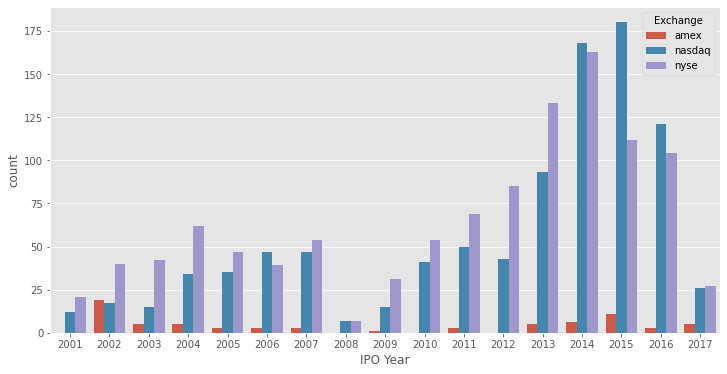

In [31]:
plt.figure(figsize=(12,6))
sns.countplot(x = 'IPO Year', hue = 'Exchange', data = listings_concat_post2000);plt.show()

## <font face="gotham" color="purple">Merging Different Time Series</font>

This example shows that bonds and stock markets are not open in the same days. Especially useful when you retrieve the data from different sources.

```set``` is the function to return a set with unique values, the difference of both sets are the days that either of them is closed, but not both.

In [32]:
start = dt.datetime(2018, 1, 1)
sp500 = pdr.data.DataReader('sp500', 'fred', start).dropna()
us10y = pdr.data.DataReader('DGS10', 'fred', start).dropna()

A simple trick can show if a specific date presents in either series.

In [33]:
try:
    sp500.loc['2018-10-08']
except:
    print('No data on this date')

In [34]:
try:
    us10y.loc['2018-10-08']
except:
    print('No data on this date')

No data on this date


The set of $\text{S&P}$ dates minus the set of $\text{US10y}$ returns the dates that stocks opened while bonds closed, vice versa we obtain the dates bonds market opened.

In [35]:
set(sp500.index)-set(us10y.index) # A - B return a set of elements that only A has

{Timestamp('2018-10-08 00:00:00'),
 Timestamp('2018-11-12 00:00:00'),
 Timestamp('2019-10-14 00:00:00'),
 Timestamp('2019-11-11 00:00:00'),
 Timestamp('2020-10-12 00:00:00'),
 Timestamp('2020-11-11 00:00:00'),
 Timestamp('2021-10-11 00:00:00'),
 Timestamp('2021-11-11 00:00:00'),
 Timestamp('2022-09-16 00:00:00')}

In [36]:
set(us10y.index)-set(sp500.index) # B - A return a set of elements that only B has

{Timestamp('2021-04-02 00:00:00')}

```inner``` means obtain the intersection set of two time indices, i.e. the days both markets open in this case. 

In [37]:
us10y.join(sp500, how='inner')

,DGS10,sp500
DATE,,
2018-01-02,2.46,2695.81
2018-01-03,2.44,2713.06
2018-01-04,2.46,2723.99
2018-01-05,2.47,2743.15
2018-01-08,2.49,2747.71
...,...,...
2022-09-09,3.33,4067.36
2022-09-12,3.37,4110.41
2022-09-13,3.42,3932.69


However, ```pandas_reader``` has a simpler solution, by importing as a group from FRED, which solve this issue automatically.

In [38]:
code_name = ['sp500', 'DGS10']
start = dt.datetime(2018, 1, 1)
df = pdr.data.DataReader(code_name, 'fred', start).dropna()

Check if both sets of indices are the same this time.

In [39]:
print(set(df['sp500'].index)-set(df['DGS10'].index))
print(set(df['DGS10'].index)-set(df['sp500'].index))

set()
set()


The sets are empty, we have obtained the same time indices.

## <font face="gotham" color="purple">```Period``` function</font>

Any ```datetime``` object can display a timestamp.

In [40]:
time_stamp = pd.Timestamp(dt.datetime(2021,12,25)); time_stamp

Timestamp('2021-12-25 00:00:00')

In [41]:
filter_dunder(time_stamp) # take a look what methods or features 

,meth_attr
0,_date_repr
1,_freq
2,_freqstr
3,_repr_base
4,_round
...,...
78,value
79,week
80,weekday
81,weekofyear


In [42]:
print(time_stamp.year)
print(time_stamp.month)
print(time_stamp.day)
print(time_stamp.day_name())

2021
12
25
Saturday


In [43]:
print(time_stamp)

2021-12-25 00:00:00


The ```period``` function literally creates a period, it is not a single point of time anymore.

In [44]:
period = pd.Period('2021-8'); period

Period('2021-08', 'M')

In [45]:
period_2 = pd.Period('2021-8-28', 'D'); period_2

Period('2021-08-28', 'D')

In [46]:
print(period + 2)

2021-10


In [47]:
print(period_2 - 10)

2021-08-18


## <font face="gotham" color="purple">Sequence of Time</font>

Each object of ```date_range``` is a ```Timestamp``` object.

In [48]:
index = pd.date_range(start = '2010-12', end = '2021-12', freq = 'M')
index

DatetimeIndex(['2010-12-31', '2011-01-31', '2011-02-28', '2011-03-31',
               '2011-04-30', '2011-05-31', '2011-06-30', '2011-07-31',
               '2011-08-31', '2011-09-30',
               ...
               '2021-02-28', '2021-03-31', '2021-04-30', '2021-05-31',
               '2021-06-30', '2021-07-31', '2021-08-31', '2021-09-30',
               '2021-10-31', '2021-11-30'],
              dtype='datetime64[ns]', length=132, freq='M')

Convert to period index. The difference is that period index is usually for flow variables, it shows the accumulation rather than a snap shot of status.

In [49]:
index.to_period()

PeriodIndex(['2010-12', '2011-01', '2011-02', '2011-03', '2011-04', '2011-05',
             '2011-06', '2011-07', '2011-08', '2011-09',
             ...
             '2021-02', '2021-03', '2021-04', '2021-05', '2021-06', '2021-07',
             '2021-08', '2021-09', '2021-10', '2021-11'],
            dtype='period[M]', length=132)

Let's print $10$ days from 1st Dec 2021 onward.

In [50]:
index_2 = pd.date_range(start= '2021-12-1', periods = 10)
for day in index_2:
    print(str(day.day) + ':' + day.day_name())

1:Wednesday
2:Thursday
3:Friday
4:Saturday
5:Sunday
6:Monday
7:Tuesday
8:Wednesday
9:Thursday
10:Friday


In [51]:
index_2

DatetimeIndex(['2021-12-01', '2021-12-02', '2021-12-03', '2021-12-04',
               '2021-12-05', '2021-12-06', '2021-12-07', '2021-12-08',
               '2021-12-09', '2021-12-10'],
              dtype='datetime64[ns]', freq='D')

## <font face="gotham" color="purple">Create a Time Series</font>

To simulate time series, we need to generate time series with proper indices, something matching the real time series.

Let's use the time index generated above, give it a name ```Time```. 

In [52]:
time_series = pd.DataFrame({'Time':index})

In [53]:
time_series.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132 entries, 0 to 131
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Time    132 non-null    datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 1.2 KB


In [54]:
data = np.random.randn(len(index), 2) # two columns of Gaussian generated variables

Two series and an index, a simple line of code to create.

In [55]:
time_series = pd.DataFrame(data = data, index = index, columns =['Series_1', 'Series_2'])

Pandas plot function is convenient for fast plotting, FYI colormap is <a href='https://matplotlib.org/2.0.2/examples/color/colormaps_reference.html'> here </a>.

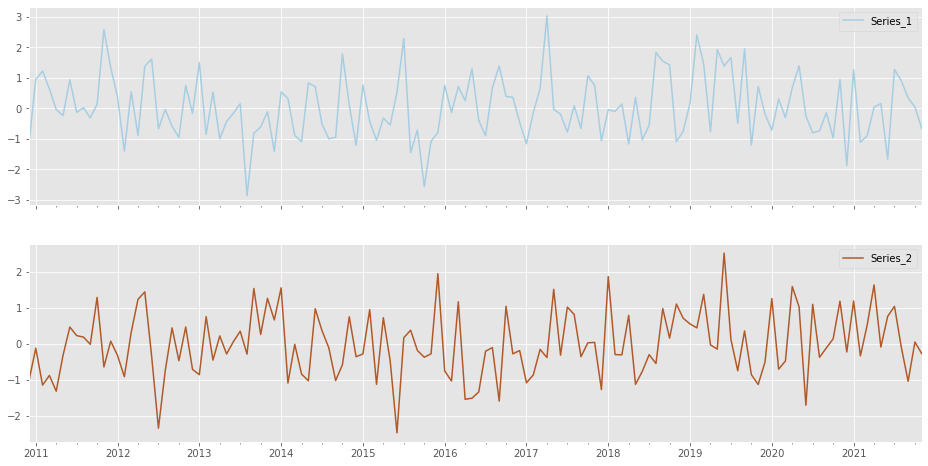

In [56]:
time_series.plot(colormap = 'Paired', figsize=(16, 8), subplots=True); plt.show()

## <font face="gotham" color="purple">Upsampling</font>

Upsampling is a technique for increasing the frequency or filling missing observations of a time series.

As an example, retrieve some real time series.

In [57]:
tesla_stockp = pdr.data.DataReader(name = 'TSLA', data_source = 'yahoo', start = '2018-1-1', end = dt.datetime.today())

In [58]:
tesla_stockp.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2022-09-12,305.489990,300.399994,300.720001,304.420013,48674600.0,304.420013
2022-09-13,297.399994,290.399994,292.899994,292.130005,68229600.0,292.130005
2022-09-14,306.000000,291.640015,292.239990,302.609985,72628700.0,302.609985
2022-09-15,309.119995,300.720001,301.829987,303.750000,64795500.0,303.750000
2022-09-16,303.709991,295.600006,299.609985,303.350006,86949500.0,303.350006


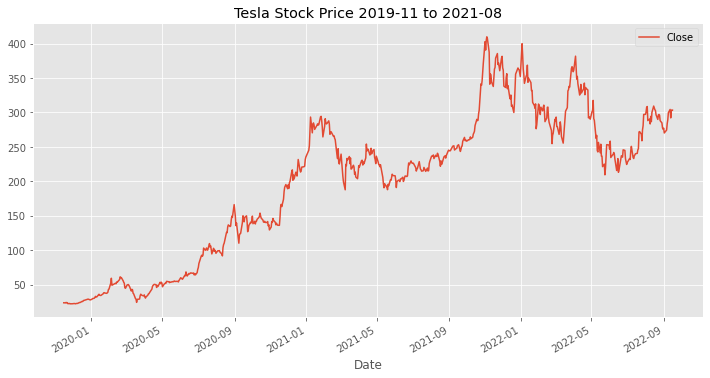

In [59]:
tesla_stockp.loc['2019-11-15':, ['Close']].plot(figsize=(12, 6), 
                                                            title = 'Tesla Stock Price 2019-11 to 2021-08'); plt.show()

Notice that weekends and holidays are excluded from the index, which means there won't be any ```n/a``` on those days, such as ```2018-01-06``` and ```2018-01-06``` as below.

In [60]:
tesla_stockp.head(10)

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2018-01-02,21.474001,20.733334,20.799999,21.368668,65283000.0,21.368668
2018-01-03,21.683332,21.036667,21.400000,21.150000,67822500.0,21.150000
2018-01-04,21.236668,20.378668,20.858000,20.974667,149194500.0,20.974667
2018-01-05,21.149332,20.799999,21.108000,21.105333,68868000.0,21.105333
2018-01-08,22.468000,21.033333,21.066668,22.427334,147891000.0,22.427334
2018-01-09,22.586666,21.826668,22.344000,22.246000,107199000.0,22.246000
2018-01-10,22.466667,22.000000,22.146667,22.320000,64648500.0,22.320000
2018-01-11,22.987333,22.217333,22.349333,22.530001,99682500.0,22.530001
2018-01-12,22.694000,22.244667,22.575333,22.414667,72376500.0,22.414667


Upsampling to including non-trade days, such as weekends and holidays.

In [61]:
tesla_stockp.asfreq('D').head(10)

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2018-01-02,21.474001,20.733334,20.799999,21.368668,65283000.0,21.368668
2018-01-03,21.683332,21.036667,21.400000,21.150000,67822500.0,21.150000
2018-01-04,21.236668,20.378668,20.858000,20.974667,149194500.0,20.974667
2018-01-05,21.149332,20.799999,21.108000,21.105333,68868000.0,21.105333
2018-01-06,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-07,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-08,22.468000,21.033333,21.066668,22.427334,147891000.0,22.427334
2018-01-09,22.586666,21.826668,22.344000,22.246000,107199000.0,22.246000
2018-01-10,22.466667,22.000000,22.146667,22.320000,64648500.0,22.320000


In the plot below, you can notice some obvious gaps now, because we have inserted weekend indices with ```n/a```.

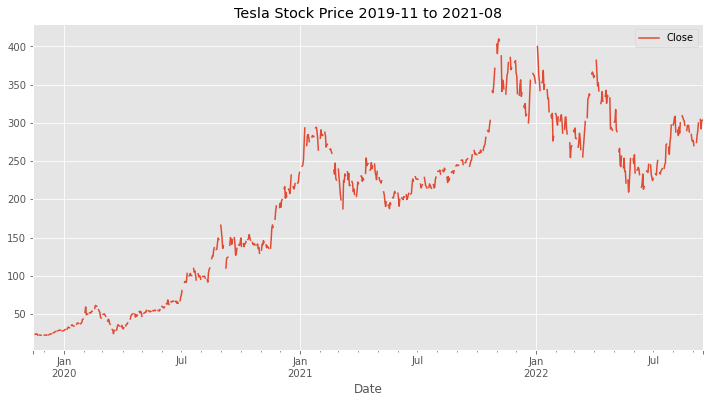

In [62]:
tesla_stockp.asfreq('D').loc['2019-11-15':, ['Close']].plot(figsize=(12, 6), 
                                                            title = 'Tesla Stock Price 2019-11 to 2021-08'); plt.show()

## <font face="gotham" color="purple"> Compare Each Years Data</font>

```reset_index``` can drop index, so we can align each year as parallel columns.

In [63]:
tesla_prices = pd.DataFrame() # placeholder dataframe
for year in ['2018', '2019', '2020', '2021']:
    price_per_year = tesla_stockp.loc[year, ['Close']].reset_index(drop=True)
    price_per_year.rename(columns={'Close':year+' close'}, inplace=True)
    tesla_prices = pd.concat([tesla_prices, price_per_year], axis=1)
    
tesla_prices.head()

,2018 close,2019 close,2020 close,2021 close
0,21.368668,20.674667,28.684000,243.256668
1,21.150000,20.024000,29.534000,245.036667
2,20.974667,21.179333,30.102667,251.993332
3,21.105333,22.330667,31.270666,272.013336
4,22.427334,22.356667,32.809334,293.339996


Here we can visually compare the performance of each year.

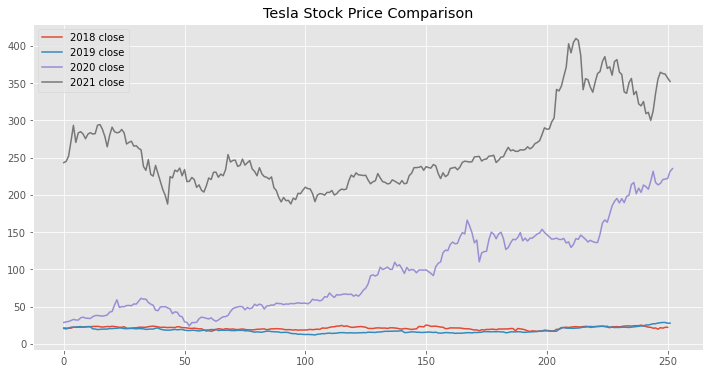

In [64]:
tesla_prices.plot(figsize=(12, 6), title ='Tesla Stock Price Comparison'); plt.show()

## <font face="gotham" color="purple"> Resampling</font>

```.asfreq``` can change the series the frequency, here we use a keyword ```W-Wed``` to change the series to weekly Wednesday. 

In [65]:
tesla_stockp['Close'].asfreq('W-Wed').tail()

Date
2022-08-17    303.996674
2022-08-24    297.096680
2022-08-31    275.609985
2022-09-07    283.700012
2022-09-14    302.609985
Freq: W-WED, Name: Close, dtype: float64

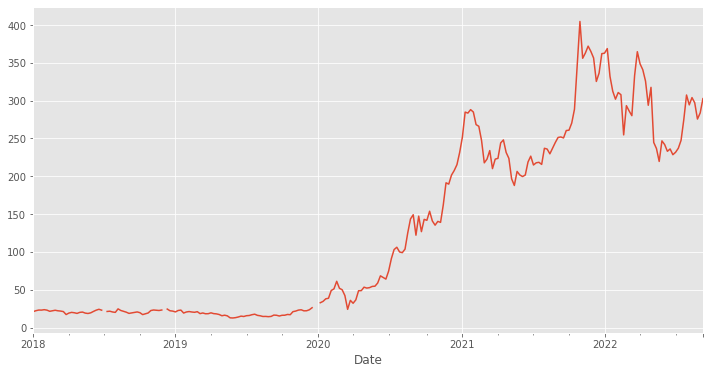

In [66]:
tesla_stockp['Close'].asfreq('W-Wed').plot(figsize = (12, 6)); plt.show()

If we use ```M``` frequency, pandas will pick the last day of each month.

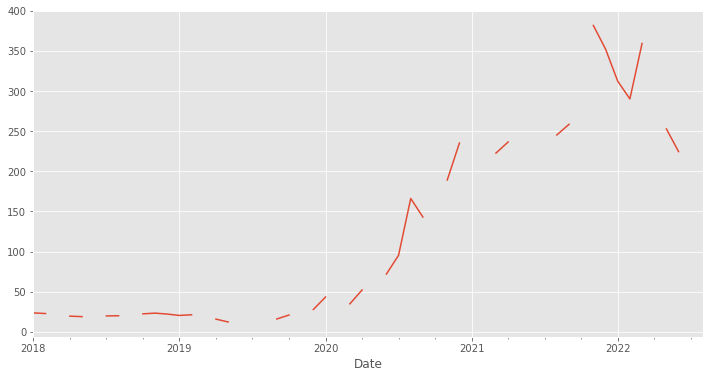

In [67]:
tesla_stockp['Close'].asfreq('M').plot(figsize = (12, 6)); plt.show()

But it turns out that many days at the end of month are weekend, which causes multiple ```n/a``` values and breaks in the plots.

However ```method='bfill'``` can fill the empty observation with previous one.

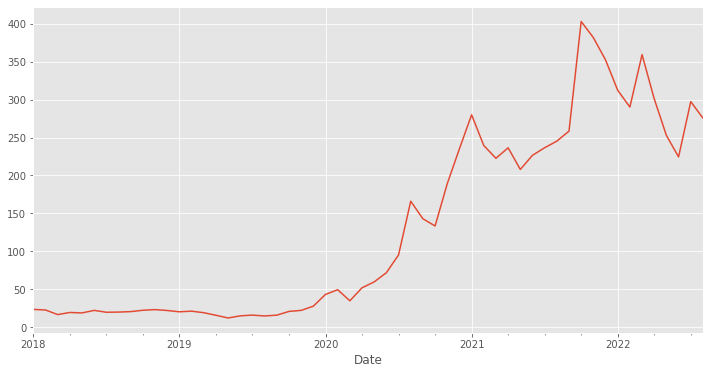

In [68]:
tesla_stockp['Close'].asfreq('M', method='bfill').plot(figsize = (12, 6)); plt.show()

## <font face="gotham" color="purple"> Lagged Variable</font>

Lagged variable usually denoted as $y_{t-i}$ where $i \in \{1, 2, 3,...\}$, in practice, we move the data at $t-i$ to current period. The example of $y_{t-1}$ is added as ```Lag_1``` column. 

Pick the close price then shift $1$ period backward. And gross daily change would be straightforward now.

In [69]:
tesla_stockp['Lag_1'] = tesla_stockp['Close'].shift()
tesla_stockp['Daily Change'] = tesla_stockp['Close'].div(tesla_stockp['Lag_1'])

In [70]:
tesla_stockp.head()

,High,Low,Open,Close,Volume,Adj Close,Lag_1,Daily Change
Date,,,,,,,,
2018-01-02,21.474001,20.733334,20.799999,21.368668,65283000.0,21.368668,NaN,NaN
2018-01-03,21.683332,21.036667,21.400000,21.150000,67822500.0,21.150000,21.368668,0.989767
2018-01-04,21.236668,20.378668,20.858000,20.974667,149194500.0,20.974667,21.150000,0.991710
2018-01-05,21.149332,20.799999,21.108000,21.105333,68868000.0,21.105333,20.974667,1.006230
2018-01-08,22.468000,21.033333,21.066668,22.427334,147891000.0,22.427334,21.105333,1.062638


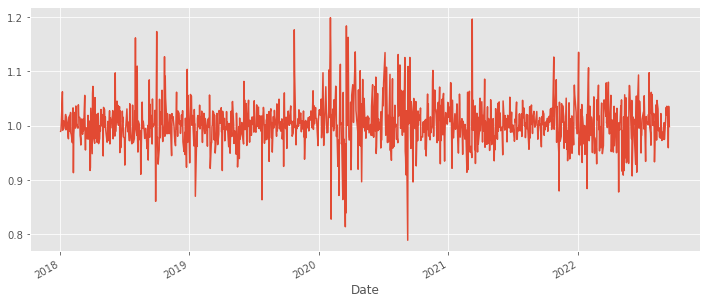

In [71]:
tesla_stockp['Daily Change'].plot(figsize = (12, 5)); plt.show()

You can also plot histogram.

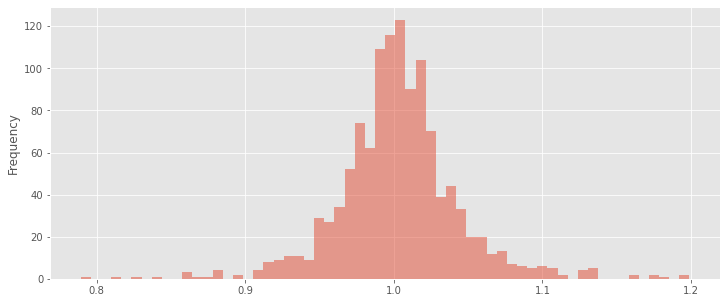

In [105]:
ax = tesla_stockp['Daily Change'].plot.hist(bins=60, alpha=0.5, figsize = (12, 5))

## <font face="gotham" color="purple">  Growth Rate </font>

The daily change rate or rate of change has a convenient computing method in Pandas.

In [73]:
tesla_stockp['change_pct'] = tesla_stockp['Close'].pct_change() 

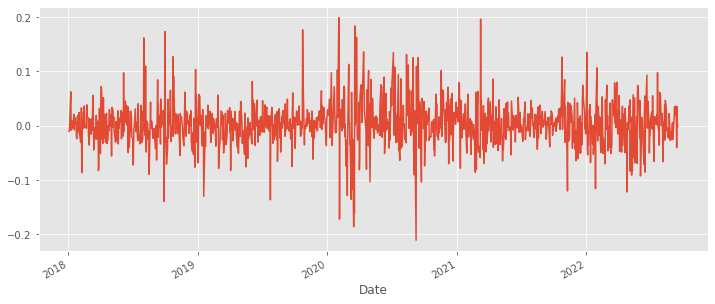

In [106]:
tesla_stockp['change_pct'].plot(figsize = (12, 5)); plt.show()

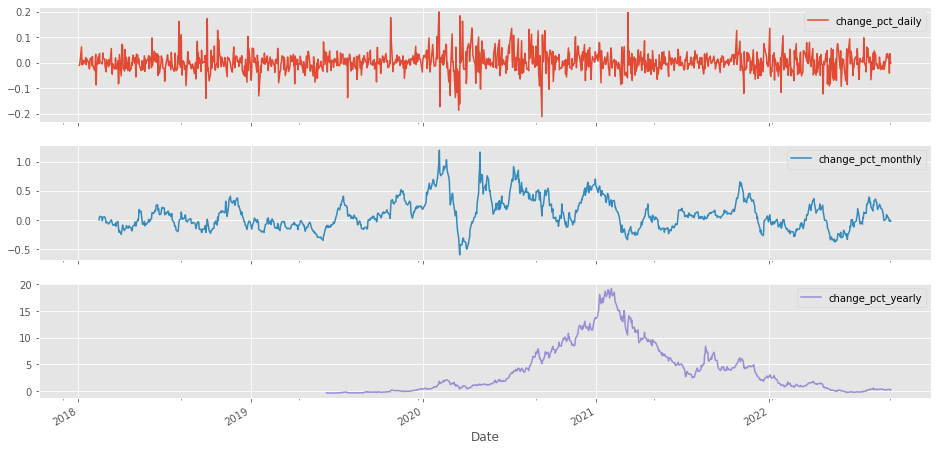

In [75]:
tesla_stockp['change_pct_daily'] = tesla_stockp['Close'].pct_change()
tesla_stockp['change_pct_monthly'] = tesla_stockp['Close'].pct_change(periods=30)
tesla_stockp['change_pct_yearly'] = tesla_stockp['Close'].pct_change(periods=360)
tesla_stockp[['change_pct_daily', 'change_pct_monthly', 'change_pct_yearly']]\
.plot(subplots=True, figsize = (16, 8)); plt.show()

In [76]:
# SP500, Gold, Crude oil, Gold, Bitcoin, Nikkei 225
assets_tickers =  ['^GSPC', 'GC=F', 'CL=F', 'BTC-USD', '^N225']
legends = ['SP500', 'Gold', 'Crude oil', 'Gold', 'Bitcoin', 'Nikkei 225']
start_date = '2010-1-1'
end_date = '2021-12-1'
assets_price = pdr.data.DataReader(name = assets_tickers, data_source = 'yahoo', start = start_date, end = end_date)

In [77]:
normalized_prices = assets_price['Close'].div(assets_price['Close'].iloc[0]).mul(100)

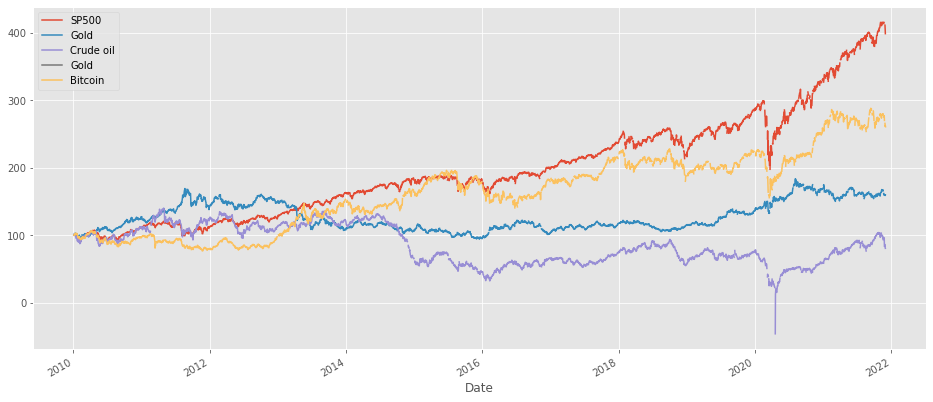

In [78]:
price_plot = normalized_prices.plot(figsize = (16, 7))
price_plot.legend(legends)
plt.show()

## Correlation

In [79]:
assets_close = assets_price['Close']
assets_close.columns = ['SP500', 'Crude oil', 'Gold', 'Bitcoin', 'Nikkei 225']

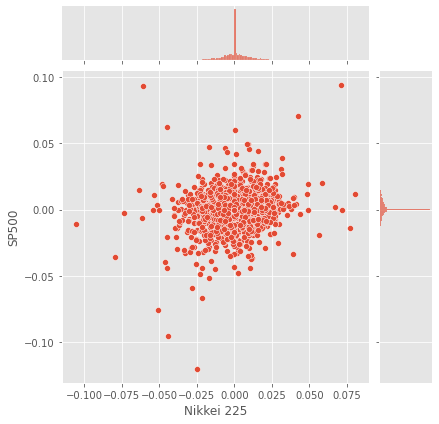

In [80]:
sns.jointplot(x='Nikkei 225', y='SP500', data=assets_close.pct_change()); plt.show()

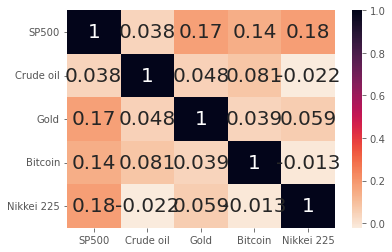

In [81]:
assets_corr = assets_close.pct_change().corr()
sns.heatmap(assets_corr, annot=True, cmap = sns.cm.rocket_r,annot_kws={"size": 20}); plt.show()

Furthermore, ```clustermap``` can organize similar data by similarity, which brings more insight into the data set.

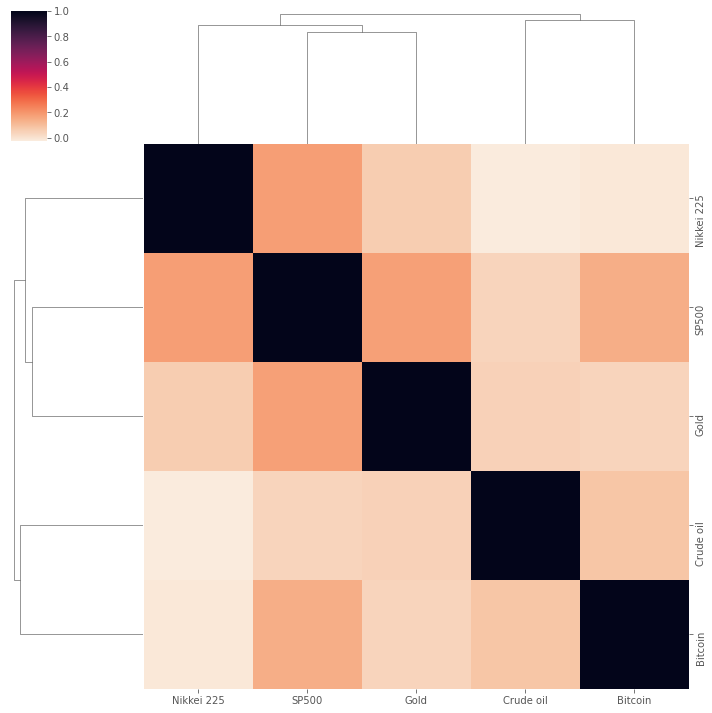

In [82]:
sns.clustermap(assets_corr, cmap = sns.cm.rocket_r); plt.show()

In [83]:
df = pdr.data.DataReader(['JPM', '^RUT'], 'yahoo', start)['Close']
df.columns = ['JPM', 'Russel2000']
df_change = df.pct_change()
df_change.columns = ['JPM_ret', 'Russel2000_ret']
df_change.head()

,JPM_ret,Russel2000_ret
Date,,
2018-01-02,NaN,NaN
2018-01-03,0.001019,0.001658
2018-01-04,0.009069,0.002022
2018-01-05,-0.006420,0.002758
2018-01-08,0.001477,0.001154


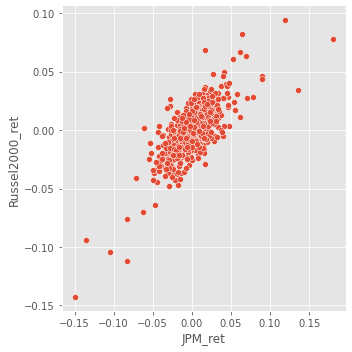

In [84]:
sns.relplot(x='JPM_ret', y='Russel2000_ret', data=df_change);plt.show()

## Normalization

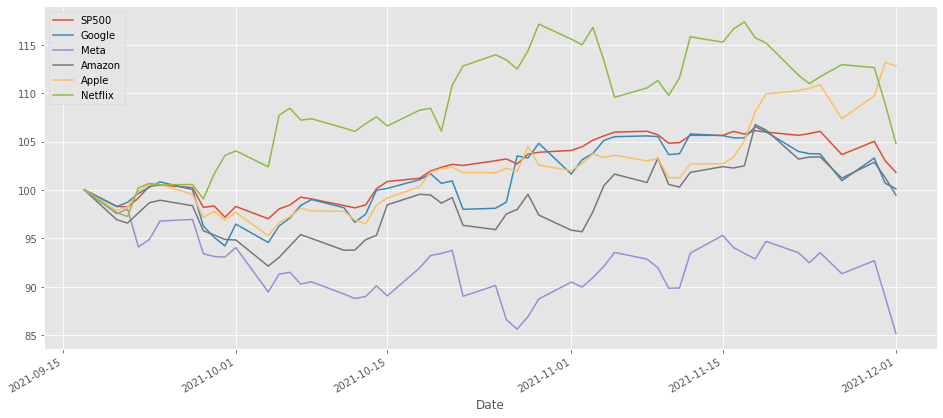

In [85]:
assets_tickers =  ['^GSPC', 'GOOG', 'FB', 'AMZN', 'AAPL', 'NFLX']
legends = ['SP500', 'Google', 'Meta', 'Amazon', 'Apple', 'Netflix']
start_date = '2010-1-1'
end_date = '2021-12-1'
assets_price = pdr.data.DataReader(name = assets_tickers, data_source = 'yahoo', start = start_date, end = end_date).dropna()

price_plot = assets_price['Close'].div(assets_price['Close'].iloc[0]).mul(100).plot(figsize = (16, 7), grid = True)
price_plot.legend(legends)
plt.show()

Make them start from $0$.

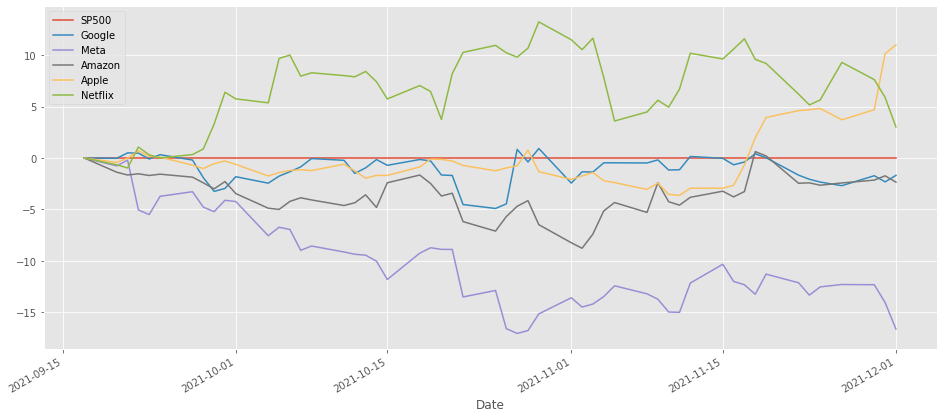

In [86]:
normalized = assets_price['Close'].div(assets_price['Close'].iloc[0]).mul(100)

price_plot = normalized[assets_tickers].sub(normalized['^GSPC'], axis = 0).plot(figsize = (16, 7), grid = True)
price_plot.legend(legends)
plt.show()

## Changing Data Frequency

In [87]:
start = '2021-1-15'
end = '2021-12-20'
dates = pd.date_range(start = start, end = end, freq='M')
dates

DatetimeIndex(['2021-01-31', '2021-02-28', '2021-03-31', '2021-04-30',
               '2021-05-31', '2021-06-30', '2021-07-31', '2021-08-31',
               '2021-09-30', '2021-10-31', '2021-11-30'],
              dtype='datetime64[ns]', freq='M')

In [88]:
monthly = pd.Series(data = np.arange(len(dates)), index = dates); monthly

2021-01-31     0
2021-02-28     1
2021-03-31     2
2021-04-30     3
2021-05-31     4
2021-06-30     5
2021-07-31     6
2021-08-31     7
2021-09-30     8
2021-10-31     9
2021-11-30    10
Freq: M, dtype: int32

In [89]:
weekly_dates = pd.date_range(start = start, end = end, freq='W'); weekly_dates

DatetimeIndex(['2021-01-17', '2021-01-24', '2021-01-31', '2021-02-07',
               '2021-02-14', '2021-02-21', '2021-02-28', '2021-03-07',
               '2021-03-14', '2021-03-21', '2021-03-28', '2021-04-04',
               '2021-04-11', '2021-04-18', '2021-04-25', '2021-05-02',
               '2021-05-09', '2021-05-16', '2021-05-23', '2021-05-30',
               '2021-06-06', '2021-06-13', '2021-06-20', '2021-06-27',
               '2021-07-04', '2021-07-11', '2021-07-18', '2021-07-25',
               '2021-08-01', '2021-08-08', '2021-08-15', '2021-08-22',
               '2021-08-29', '2021-09-05', '2021-09-12', '2021-09-19',
               '2021-09-26', '2021-10-03', '2021-10-10', '2021-10-17',
               '2021-10-24', '2021-10-31', '2021-11-07', '2021-11-14',
               '2021-11-21', '2021-11-28', '2021-12-05', '2021-12-12',
               '2021-12-19'],
              dtype='datetime64[ns]', freq='W-SUN')

Conform the data with new index. ```bfill``` and ```ffill``` mean fill backward and forward.

In [90]:
monthly.reindex(weekly_dates).head(10)

2021-01-17    NaN
2021-01-24    NaN
2021-01-31    0.0
2021-02-07    NaN
2021-02-14    NaN
2021-02-21    NaN
2021-02-28    1.0
2021-03-07    NaN
2021-03-14    NaN
2021-03-21    NaN
Freq: W-SUN, dtype: float64

In [91]:
monthly.reindex(weekly_dates, method = 'bfill').head(10)

2021-01-17    0.0
2021-01-24    0.0
2021-01-31    0.0
2021-02-07    1.0
2021-02-14    1.0
2021-02-21    1.0
2021-02-28    1.0
2021-03-07    2.0
2021-03-14    2.0
2021-03-21    2.0
Freq: W-SUN, dtype: float64

In [92]:
monthly.reindex(weekly_dates, method = 'ffill').head(10)

2021-01-17    NaN
2021-01-24    NaN
2021-01-31    0.0
2021-02-07    0.0
2021-02-14    0.0
2021-02-21    0.0
2021-02-28    1.0
2021-03-07    1.0
2021-03-14    1.0
2021-03-21    1.0
Freq: W-SUN, dtype: float64

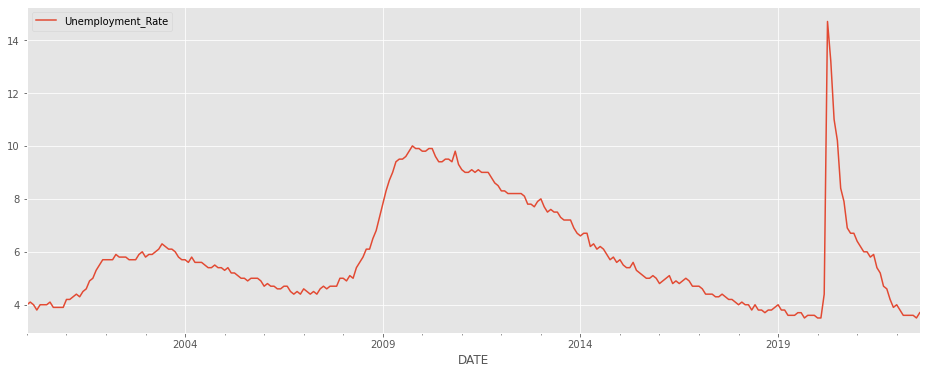

In [93]:
df_unempl = pdr.data.DataReader(name='UNRATE', data_source='fred', start = '2000-1-1', end = dt.date.today())
df_unempl.columns = ['Unemployment_Rate']
df_unempl.plot(figsize=(16, 6))
plt.show()

In [94]:
df_unempl.head()

,Unemployment_Rate
DATE,
2000-01-01,4.0
2000-02-01,4.1
2000-03-01,4.0
2000-04-01,3.8
2000-05-01,4.0


Change the frequency to weekly data, the missing values will be filled by existing values.

In [95]:
df_unempl_bfill = df_unempl.asfreq('W', method='bfill')
df_unempl_ffill = df_unempl.asfreq('W', method='ffill')
df_unempl_concat = pd.concat([df_unempl_bfill, df_unempl_ffill], axis=1)
df_unempl_concat.columns =['unemp_rate_bfilled_weekly', 'unemp_rate_ffilled_weekly']

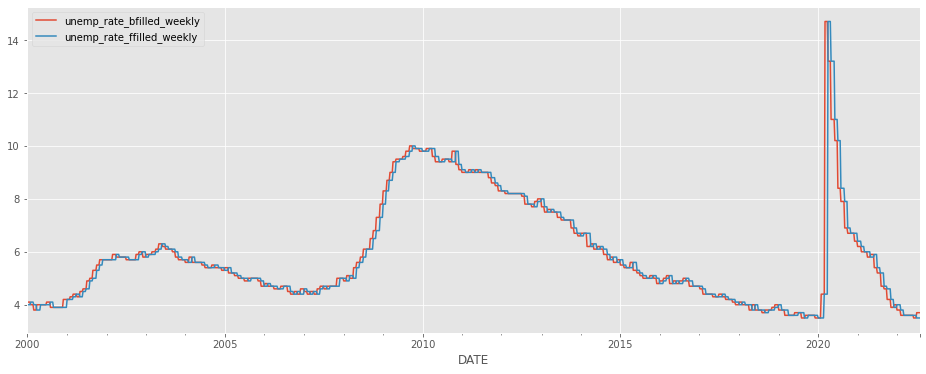

In [96]:
df_unempl_concat.plot(figsize=(16, 6)); plt.show()

## Interpolation

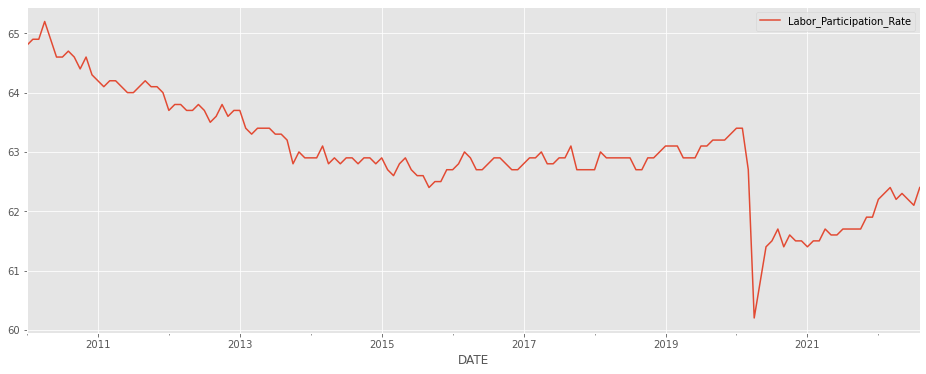

In [97]:
lab_part = pdr.data.DataReader(name='CIVPART', data_source='fred', start = '2010-1-1', end = dt.date.today())
lab_part.columns = ['Labor_Participation_Rate']
lab_part.plot(figsize=(16, 6))
plt.show()

In [98]:
daily_dates = pd.date_range(start=lab_part.index.min(), end=lab_part.index.max(), freq='D')

In [99]:
lab_part_daily = lab_part.reindex(daily_dates)
lab_part_daily['forward_fill'] = lab_part_daily['Labor_Participation_Rate'].ffill()
lab_part_daily['interpolation'] = lab_part_daily['Labor_Participation_Rate'].interpolate() # this is exactly the plot above

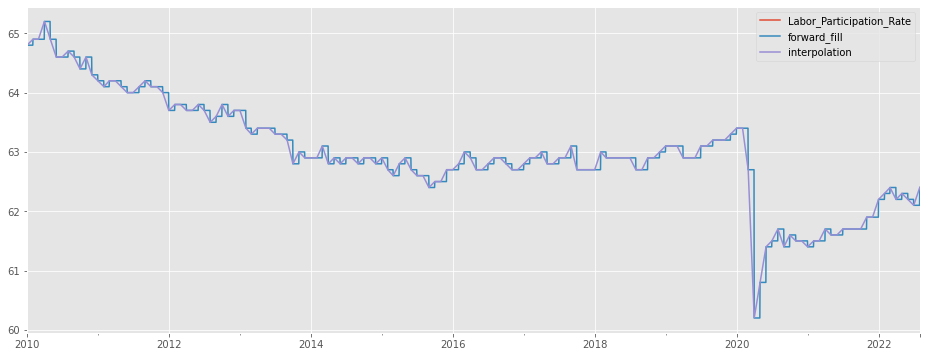

In [100]:
lab_part_daily.plot(figsize=(16, 6)); plt.show()

In [101]:
df = pdr.data.DataReader(name=['DFII10','GOLDAMGBD228NLBM'], data_source='fred', start = '2010-1-1', end = dt.date.today())

RemoteDataError: Unable to read URL: https://fred.stlouisfed.org/graph/fredgraph.csv?id=GOLDAMGBD228NLBM
Response Text:
b'<!DOCTYPE html>\r\n<html lang="en">\r\n<head>\r\n    <meta charset="utf-8">\r\n    <meta http-equiv="X-UA-Compatible" content="IE=edge">\r\n    <meta name="viewport" content="width=device-width, initial-scale=1">\r\n    <title>Error - St. Louis Fed</title>\r\n    <meta name="description" content="">\r\n    <meta name="keywords" content="">\r\n    <link rel="stylesheet" type="text/css" href="/css/bootstrap.custom.min.css?1551876305">\r\n    <link rel="stylesheet" type="text/css" href="/css/home.min.css?1553087253">\r\n    <link rel="stylesheet" type="text/css" href="/assets/fontawesome-free/css/all.min.css">\r\n    <link rel="stylesheet" type="text/css" href="/assets/select2/dist/css/select2.min.css">\r\n    <style>p {\r\n        margin-bottom: 1.5em;\r\n    }</style>\r\n</head>\r\n<body>\r\n<link rel="preconnect" href="https://fonts.gstatic.com">\n<link href="https://fonts.googleapis.com/css2?family=Roboto&display=swap" rel="stylesheet">\n<link href="https://fonts.googleapis.com/css2?family=Roboto+Slab&display=swap" rel="stylesheet">\n<!--googleoff: snippet-->\n<a href="#content-container" class="sr-only sr-only-focusable">Skip to main content</a>\n<!--googleon: snippet-->\n<a name="top" id="top"></a>\n<!--[if lt IE 7 ]>\n<div id="container" class="ie6 container"><![endif]-->\n<!--[if IE 7 ]>\n<div id="container" class="ie7 container"><![endif]-->\n<!--[if IE 8 ]>\n<div id="container" class="ie8 container"><![endif]-->\n<!--[if IE 9 ]>\n<div id="container" class="ie9 container"><![endif]-->\n<!--[if IE]>\n<div id="container" class="ie container"><![endif]-->\n<!--[if !(IE)]><!-->\n<div id="container" class="container">\n  <!--<![endif]-->\n  <span class="EL-header-and-subheader">\n    <div class="header-not-home EL-nonhomepage-header">\n            <div id="hidden-user" class=\'hide\'></div>\n            <div id="action-modal"></div>\n            <div class=\'col-xs-12 center-content\' style="padding: 0px; height: inherit;">\n                <div class="col-md-4 col-xs-3" style="padding-left: 15px; padding-right: 15px;">\n                    <a class="research-logo-gtm" target="_" href="//research.stlouisfed.org/">\n                        <img class="header-logo-eagle hidden-sm hidden-xs" src="//fred.stlouisfed.org/images/masthead-no-bank.png" alt="Eagle Economic Research Logo">\n                        <img class="header-logo-eagle visible-sm-block visible-xs-block" src="//fred.stlouisfed.org/images/logo-eagle.png" alt="Eagle Logo">\n                    </a>\n                </div>\n                <div class="fred-logo-div col-xs-6 visible-sm-block visible-xs-block" style="padding-left: 15px; padding-right: 15px;">\n                    <a class="fred-logo-gtm" href="//fred.stlouisfed.org/">\n                        <picture>\n                            <img class="header-logo" src="//fred.stlouisfed.org/images/fred-masthead-mobile-2x.png" alt="mini fred logo">\n                        </picture>\n                    </a>\n                </div>\n                <div class="col-md-8 col-xs-3" style="padding-left: 15px; padding-right: 0px;">\n                    <ul id="blueheader-navbar" class="nav pull-right navbar-nav">\n                        <li class="blueheader-navbar-item center-content-vertically hidden-sm hidden-xs">\n                            <a class="research-resources-dropdown-gtm header-popover research-resources-popover-container" href="#">\n    <span id="research-resources-link" class="align-icon">Economic Research Resources\n        <i class="fas fa-angle-down fa-lg header-icon-padding" alt="Open Research Resources Menu Icon"></i>\n    </span>\n</a>\n\n<div id="research-resources-popover" class="hide">\n    <div class="col-xs-12 research-resources">\n        <div class="col-xs-7 research-resources-left-column">\n            <div class="research-resources-text">Explore resources provided by the Research Division at the Federal Reserve Bank of St. Louis</div>\n            <div>\n                <a rel="noopener" target="_blank" class="errd-research-link-gtm" href="https://research.stlouisfed.org" style="color: #364E71; font-family: Roboto; font-weight: 700px">research.stlouisfed.org <i class="fas fa-external-link-alt" aria-hidden="true" style="font-size: 12px"></i></a>\n            </div>\n        </div>\n        <div class="col-xs-5 research-resources-right-column">\n            <ul class="header-list-popover list-group flush-list">\n                <li class="list-group-item">\n                    <a rel="noopener" target="_blank" class="errd-research-news-gtm" href="https://research.stlouisfed.org/publications/research-news/">Research News</a>\n                </li>\n                <li class="list-group-item">\n                    <a rel="noopener" target="_blank" class="errd-economists-gtm" href="https://research.stlouisfed.org/econ/">Economists</a>\n                </li>\n                <li class="list-group-item">\n                    <a rel="noopener" target="_blank" class="errd-publications-gtm"  href="https://research.stlouisfed.org/publications/">Publications</a>\n                </li>\n                <li class="list-group-item">\n                    <a rel="noopener" target="_blank" class="errd-working-papers-gtm" href="https://research.stlouisfed.org/wp/">Working Papers</a>\n                </li>\n                <li class="list-group-item">\n                    <a rel="noopener" target="_blank" class="errd-info-services-gtm" href="https://research.stlouisfed.org/info-services.html">Information Services</a>\n                </li>\n            </ul>\n        </div>\n    </div>\n</div>\n                        </li>\n                        <li class="blueheader-navbar-item center-content-vertically hidden-sm hidden-xs">\n                            <a class="Switch-Products-gtm header-popover switchprod-popover-container" href="#">\n  <span id="switchProd" class="align-icon"> Switch Products\n    <i class="fas fa-angle-down fa-lg header-icon-padding" alt="Open Switch Products Menu Icon"></i>\n  </span>\n</a>\n\n<div id="switchprod-popover" class="hide">\n  <ul id="switch-prod-list" class="list-group switch-products-list col-xs-12" role="menu" aria-labelledby="switchProduct">\n    <li id="ham-fred-dev" class="list-group-item product-fred">\n        <a class="burger-fred-gtm" role="menuitem" tabindex="-1" href="//fred.stlouisfed.org">\n            <span class="fred-ultra-selected fred-ultra burger-fred-gtm">FRED</span>\n            <span class="pull-right switch-icon-padding burger-fred-gtm"><img src="//fred.stlouisfed.org/images/favicon.ico" alt="" width="16" height="16"></span>\n        </a>\n      </li>\n      <li id="ham-alfred" class="hover-nav list-group-item">\n          <a rel="noopener" target="_blank" class="burger-alfred-gtm" role="menuitem" tabindex="-1" href="//alfred.stlouisfed.org">\n            <span class="fred-thin burger-alfred-gtm">AL</span>\n            <span class="fred-ultra burger-alfred-gtm">FRED</span>\n            <span class="pull-right switch-icon-padding burger-alfred-gtm"><img src="//fred.stlouisfed.org/images/greyRect.png" alt="" width="16" height="16"></span>\n        </a>\n      </li>\n      <li id="ham-fraser" class="hover-nav list-group-item">\n          <a rel="noopener" target="_blank" class="burger-fraser-gtm" role="menuitem" tabindex="-1" href="https://fraser.stlouisfed.org/">\n            <span class="fred-ultra burger-fraser-gtm">FRASER</span>\n            <span class="pull-right switch-icon-padding burger-fraser-gtm"><img src="//fred.stlouisfed.org/images/greyRect.png" alt="" width="16" height="16" onerror="this.src=\'https://fred.stlouisfed.org/images/favicons/favicon-16x16.png\'"></span>\n        </a>\n      </li>\n      <li id="ham-ecolowdown" class="hover-nav-econ hover-nav list-group-item">\n          <a rel="noopener" target="_blank" class="burger-econlowdown-gtm" role="menuitem" tabindex="-1" href="https://www.econlowdown.org/">\n            <span class="fred-ultra-econ burger-econlowdown-gtm">ECON<br>LOWDOWN</span>\n            <span class="pull-right burger-econlowdown-gtm" style="padding-top: 15px"><img src="//fred.stlouisfed.org/images/greyRect.png" alt="" width="16" height="16" onerror="this.src=\'https://fred.stlouisfed.org/images/favicons/favicon-16x16.png\'"></span>\n        </a>\n    </li>\n</ul>\n</div>                        </li>\n                        <li class="blueheader-navbar-item center-content-vertically hidden-sm hidden-xs">\n                            <div class="hidden-xs" id="signin-wrap">\n                                <div id="user-nav" class="EL-my-account-link"></div>\n                            </div>\n                        </li>\n                        <li class="blueheader-navbar-item center-content-vertically visible-sm-block visible-xs-block">\n                            <a class="hamburger-popover-container header-popover hamburger-gtm" href="#">\n    <i id="hamburger" class="fas fa-bars hamburger-header" alt="Open Mobile Hamburger Menu"></i>\n</a>\n\n<div id="hamburger-popover" class="hide">\n    <div class="hamburger-search-padding">\n        <div class=\'input-group\'>\n            <input type="text" class="form-control search-input nav-search" placeholder="Search FRED data...">\n            <span class="input-group-btn">\n                <button class="btn search-submit nav-search-button" type="submit">\n                    <i class="fa fa-search" alt="Submit Mobile Hamburger Search"></i>\n                </button>\n            </span>\n        </div>\n    </div>\n    <div id="hamburger-navigation">\n        <div id="hamburger-home">\n            <ul class="list-group flush-list hamburger-list col-xs-12">\n                <li class="list-group-item">\n                    <a class="burger-calendar-gtm" href="https://fred.stlouisfed.org/releases/calendar">Release Calendar</a>\n                </li>\n                <li class="list-group-item hamburger-menu-item" onclick="hamburgerMenuNavigation(\'hamburger-tools\')">\n                    <a class="burger-tools-gtm" href="#">FRED Tools\n                        <i class="fas fa-angle-right hamburger-nxt-page-icon" alt="FRED Tools Hamburger Submenu Icon"></i>\n                    </a>\n                </li>\n                <li class="list-group-item">\n                    <a class="burger-blog-gtm" href="https://fredblog.stlouisfed.org">FRED Blog</a>\n                </li>\n                <li class="list-group-item">\n                    <a class="burger-news-gtm" href="https://news.research.stlouisfed.org/category/fred-announcements/">FRED News</a>\n                </li>\n                <li class="list-group-item hamburger-menu-item" onclick="hamburgerMenuNavigation(\'hamburger-about-fred\')">\n                    <a class="burger-about-gtm" href="#">About FRED\n                        <i class="fas fa-angle-right hamburger-nxt-page-icon" alt="About FRED Hamburger Submenu Icon"></i>\n                    </a>\n                </li>\n                <li class="list-group-item">\n                    <a class="burger-myaccount-gtm" href="https://fredaccount.stlouisfed.org">My Account</a>\n                </li>\n            </ul>\n            <ul class="list-group flush-list hamburger-list col-xs-12">\n                <li class="list-group-item hamburger-menu-item" onclick="hamburgerMenuNavigation(\'hamburger-products\')">\n                    <a class="burger-switch-gtm" href="#">\n                        Switch Products<i class="fas fa-angle-right hamburger-nxt-page-icon" alt="Switch Products Hamburger Submenu Icon"></i>\n                    </a>\n                </li>\n                <li class="list-group-item hamburger-menu-item" onclick="hamburgerMenuNavigation(\'hamburger-research\')">\n                    <a class="burger-resources-gtm" href="#">\n                        Economic Research Resources<i class="fas fa-angle-right hamburger-nxt-page-icon" alt="Economic Research Resources Hamburger Submenu Icon"></i>\n                    </a>\n                    <p>Explore resources provided by the Research Division at the Federal Reserve Bank of St. Louis.</p>\n                </li>\n            </ui>\n        </div>\n        \n        <div id="hamburger-about-fred" class="hide">\n            <ul class="list-group hamburger-submenu-list col-xs-12">\n                <li class="list-group-item hamburger-menu-item" onclick="hamburgerMenuNavigation(\'hamburger-home\')">\n                    <i class="fas fa-angle-left hamburger-previous-page-icon" alt="Return to Mobile/Hamburger Main Menu Icon"></i>\n                    About FRED\n                </li>\n                <li class="list-group-item">\n                    <a class="burger-fred-about-gtm" href="https://fredhelp.stlouisfed.org/fred/about/about-fred/what-is-fred/"> What is FRED</a>\n                </li>\n                <li class="list-group-item">\n                    <a class="burger-tutorials-gtm" href="https://fredhelp.stlouisfed.org"> Tutorials</a>\n                </li>\n                <li class="list-group-item">\n                    <a class="burger-data-literacy-gtm" href="https://research.stlouisfed.org/info-services/data-literacy-for-librarians/ ">\n                      Data Literacy\n                    </a>\n                </li>\n                <li class="list-group-item">\n                    <a class="burger-contact-us-gtm" href="https://fred.stlouisfed.org/contactus/"> Contact Us</a>\n                </li>\n            </ul>\n        </div>\n        \n        <div id="hamburger-tools" class="hide">\n            <ul class="list-group hamburger-submenu-list col-xs-12">\n                <li class="list-group-item hamburger-menu-item" onclick="hamburgerMenuNavigation(\'hamburger-home\')">\n                        <i class="fas fa-angle-left hamburger-previous-page-icon" alt="Return to Mobile/Hamburger Main Menu Icon"></i>\n                        FRED Tools\n                </li>\n                <li class="list-group-item">\n                    <a class="burger-fred-excel-add-in-gtm" href="https://fred.stlouisfed.org/fred-addin"> FRED Add-in for Excel</a>\n                </li>\n                <li class="list-group-item">\n                    <a class="burger-fred-api-gtm" href="https://fred.stlouisfed.org/docs/api/fred"> FRED API</a>\n                </li>\n                <li class="list-group-item">\n                    <a class="burger-fred-mobile-apps-gtm" href="https://fred.stlouisfed.org/fred-mobile"> FRED Mobile Apps</a>\n                </li>\n            </ul>\n        </div>\n        \n        <div id="hamburger-research" class="hide">\n            <ul class="list-group hamburger-submenu-list col-xs-12">\n                <li class="list-group-item hamburger-menu-item" onclick="hamburgerMenuNavigation(\'hamburger-home\')">\n                    <span>\n                        <i class="fas fa-angle-left hamburger-previous-page-icon" alt="Return to Mobile/Hamburger Main Menu Icon"></i>\n                        Economic Research Resources\n                    </span>\n                </li>\n                <li class="list-group-item">\n                    <a rel="noopener" target="_blank" class="burger-research-news-gtm" href="https://research.stlouisfed.org/publications/research-news"> Research News</a>\n                </li>\n                <li class="list-group-item">\n                    <a rel="noopener" target="_blank" class="burger-economists-gtm" href="https://research.stlouisfed.org/econ/"> Economists</a>\n                </li>\n                <li class="list-group-item">\n                    <a rel="noopener" target="_blank" class="burger-publications-gtm" href="https://research.stlouisfed.org/publications/"> Publications</a>\n                </li>\n                <li class="list-group-item">\n                    <a rel="noopener" target="_blank" class="burger-working-papers-gtm" href="https://research.stlouisfed.org/wp/"> Working Papers</a>\n                </li>\n                <li class="list-group-item">\n                    <a rel="noopener" target="_blank" class="burger-info-services-gtm" href="https://research.stlouisfed.org/info-services.html"> Information Services</a>\n                </li>\n            </ul>\n        </div>\n        \n        <div id="hamburger-products" class="hide">\n            <ul class="list-group hamburger-submenu-list col-xs-12" style="padding-bottom: 0px !important">\n                <li class="list-group-item hamburger-menu-item" onclick="hamburgerMenuNavigation(\'hamburger-home\')">\n                        <i class="fas fa-angle-left hamburger-previous-page-icon" alt="Return to Mobile/Hamburger Main Menu Icon"></i>\n                        Switch Products\n                </li>\n            </ul>\n            <ul id="switch-prod-list" class="list-group switch-products-list col-xs-12" role="menu" aria-labelledby="switchProduct">\n    <li id="ham-fred-dev" class="list-group-item product-fred">\n        <a class="burger-fred-gtm" role="menuitem" tabindex="-1" href="//fred.stlouisfed.org">\n            <span class="fred-ultra-selected fred-ultra burger-fred-gtm">FRED</span>\n            <span class="pull-right switch-icon-padding burger-fred-gtm"><img src="//fred.stlouisfed.org/images/favicon.ico" alt="" width="16" height="16"></span>\n        </a>\n      </li>\n      <li id="ham-alfred" class="hover-nav list-group-item">\n          <a rel="noopener" target="_blank" class="burger-alfred-gtm" role="menuitem" tabindex="-1" href="//alfred.stlouisfed.org">\n            <span class="fred-thin burger-alfred-gtm">AL</span>\n            <span class="fred-ultra burger-alfred-gtm">FRED</span>\n            <span class="pull-right switch-icon-padding burger-alfred-gtm"><img src="//fred.stlouisfed.org/images/greyRect.png" alt="" width="16" height="16"></span>\n        </a>\n      </li>\n      <li id="ham-fraser" class="hover-nav list-group-item">\n          <a rel="noopener" target="_blank" class="burger-fraser-gtm" role="menuitem" tabindex="-1" href="https://fraser.stlouisfed.org/">\n            <span class="fred-ultra burger-fraser-gtm">FRASER</span>\n            <span class="pull-right switch-icon-padding burger-fraser-gtm"><img src="//fred.stlouisfed.org/images/greyRect.png" alt="" width="16" height="16" onerror="this.src=\'https://fred.stlouisfed.org/images/favicons/favicon-16x16.png\'"></span>\n        </a>\n      </li>\n      <li id="ham-ecolowdown" class="hover-nav-econ hover-nav list-group-item">\n          <a rel="noopener" target="_blank" class="burger-econlowdown-gtm" role="menuitem" tabindex="-1" href="https://www.econlowdown.org/">\n            <span class="fred-ultra-econ burger-econlowdown-gtm">ECON<br>LOWDOWN</span>\n            <span class="pull-right burger-econlowdown-gtm" style="padding-top: 15px"><img src="//fred.stlouisfed.org/images/greyRect.png" alt="" width="16" height="16" onerror="this.src=\'https://fred.stlouisfed.org/images/favicons/favicon-16x16.png\'"></span>\n        </a>\n    </li>\n</ul>\n        </div>\n    </div>\n</div>\n                        </li>\n                    </ul>\n                </div>\n            </div>\n        <div id="notifications-container"></div>\n\n    </div>\n    <div class=\'sub-header center-content col-md-12 hidden-sm hidden-xs\'>\n      <div class="col-lg-3 col-md-3" style="padding-left: 15px; padding-right: 15px;" >\n          <a class="fred-logo-gtm" href="//fred.stlouisfed.org/">\n                <img id="fred-logo-subheader" src="//fred.stlouisfed.org/images/fred-logo-2x.png" alt="fred subheader logo">\n          </a>\n      </div>\n      <div class="col-lg-2 fred-trust-text center-content-vertically hidden-md hidden-sm hidden-xs">\n            Your trusted data source since 1991.\n      </div>\n      <div class="col-lg-7 col-md-9 hidden-sm hidden-xs" style="padding-left: 15px; padding-right: 15px;">\n          <div class="search-header-div pull-right col-xs-8 hidden-sm hidden-xs">\n              <div class=\'input-group EL-header-search-container\' id="search-container-header">\n                  <select id="head-search" class=\'EL-header-search\'>\n                      <option></option>\n                  </select>\n                  <input type="hidden" name="st" class="search-text-input">\n                  <span class="input-group-btn">\n                    <button class="btn search-submit-select2" id="select2-nav-search-button" type="submit">\n                        <i class="fa fa-search"></i>\n                    </button>\n                  </span>\n              </div>\n          </div>\n\n          <nav class="col-xs-12 navbar hidden-sm hidden-xs EL-main-nav" id="subheader-nav" role="navigation">\n    <div class="navbar-padding navbar-collapse collapse">\n        <ul id="subheader-navbar" class="nav pull-right navbar-nav">\n            <li class="nav-li-subheader">\n                <a href="https://fred.stlouisfed.org/releases/calendar" class="nav-releasecal-subheader-gtm">Release Calendar</a>\n            </li>\n            <li class="nav-li-subheader">\n              <a class="sub-header-nav-tools-gtm  header-popover fred-tools-container" href="#">\n  <span id="fred-tools-link" class="align-icon">FRED Tools\n    <i class="fas fa-angle-down header-icon-padding" alt="Open FRED Tools Menu Icon"></i>\n  </span>\n</a>\n\n<div id="fred-tools-popover" class="hide">\n  <ul class="header-list-popover list-group flush-list">\n    <li class="list-group-item">\n      <a class="homepage-nav-tools-fred-excel-addin-gtm" href="https://fred.stlouisfed.org/fred-addin">FRED Add-in for Excel</a>\n    </li>\n    <li class="list-group-item">\n      <a class="homepage-nav-tools-fred-api-gtm" href="https://fred.stlouisfed.org/docs/api/fred">FRED API</a>\n    </li>\n    <li class="list-group-item">\n      <a class="homepage-nav-tools-fred-mobile-gtm" href="https://fred.stlouisfed.org/fred-mobile">FRED Mobile Apps</a>\n    </li>\n  </ul>\n</div>\n            </li>\n            <li class="nav-li-subheader">\n                <a href="https://news.research.stlouisfed.org/category/fred-announcements/" class="nav-news-subheader-gtm">FRED News</a>\n            </li>\n            <li class="nav-li-subheader">\n                <a href="https://fredblog.stlouisfed.org/" class="nav-fredblog-subheader-gtm">FRED Blog</a>\n            </li>\n            <li class="nav-li-subheader">\n              \n<a class="subheader-nav-about-gtm header-popover about-fred-container" href="#">\n  <span id="about-fred-link" class="align-icon">About FRED\n    <i class="fas fa-angle-down header-icon-padding" alt="Open About FRED Menu Icon"></i>\n  </span>\n</a>\n\n<div id="about-fred-popover" class="hide">\n    <ul class="header-list-popover list-group flush-list">\n      <li class="list-group-item">\n        <a class="about-fred-what-is-gtm" href="https://fredhelp.stlouisfed.org/fred/about/about-fred/what-is-fred/">\n          What is FRED\n        </a>\n      </li>\n      <li class="list-group-item">\n        <a class="about-fred-tutorials-gtm" href="https://fredhelp.stlouisfed.org">\n          Tutorials\n        </a>\n      </li>\n      <li class="list-group-item">\n        <a class="about-research-data-literacy-gtm" href="https://research.stlouisfed.org/info-services/data-literacy-for-librarians/ ">\n          Data Literacy\n        </a>\n      </li>\n      <li class="list-group-item">\n        <a class="about-fred-contact-gtm" href="https://fred.stlouisfed.org/contactus/ ">\n          Contact Us\n        </a>\n      </li>\n    </ul>\n</div>\n            </li>\n        </ul>\n    </div>\n</nav>\n      </div>\n    </div>\n  </span>\n  <div style="padding-left: 10px; padding-right: 10px;" class="clear" id="content-container">\n\n    \n\r\n<!--BEGIN CONTENT-->\r\n<div class="error-container">\r\n    <h1>Looking for Something?</h1>\r\n    <p class="large">We\'re sorry, the page you were looking for cannot be found. Please feel free\r\n        to <a href="/contactus/">contact us</a> if the problem persists.</p>\r\n    <p class="large">Searching may help find what are you looking for. If all else fails, you can head\r\n        <a href="/">Home</a>\r\n    </p>\r\n    <form action="/searchresults" id="search-form-404">\r\n        <label for="search-text">Search for:</label><br>\r\n        <input type="text" name="st" id="search-text" size="50" class="form-control">\r\n        <input type="submit" class="btn btn-default" value="Search" id="404-search-button" name="404-search-button">\r\n    </form>\r\n</div>\r\n<link href="/css/footer.min.css?1553087256" rel="stylesheet" media="all">\r\n<!--END CONTENT-->\r\n    <br class="clear">\n</div>\n\n    <div id="footer" class="EL-footer hidden-print row ">\n        <a name="foot-search-a" class="xs-anchor"></a>\n       <form action="//fred.stlouisfed.org/searchresults" id="foot-search-form" class="visible-xs-block col-xs-12">\n           <div id="foot-search-container">\n               <input type="text" id="foot-search" name="st" class="js-placeholder" title="Search FRED"><button type=\'submit\' class="pull-right" id="foot-search-button">&nbsp;</button>\n           </div>\n       </form>\n\n       \n        <div class="col-xs-12 col-sm-2">\n            <ul>\n                <li class="footer-section-header">SERVICES</li>\n                <li><a href="//fred.stlouisfed.org/">FRED&reg;</a></li>\n                <li><a href="//alfred.stlouisfed.org/">ALFRED&reg;</a></li>\n                <li><a href="//fraser.stlouisfed.org">FRASER&reg;</a></li>\n                <li><a href="//ideas.repec.org">IDEAS</a></li>\n            </ul>\n        </div>\n\n        <div class="col-xs-12 col-sm-2 col-md-3">\n            <ul>\n                <li class="footer-section-header">RESEARCH</li>\n                <li><a href="//research.stlouisfed.org/regecon/">Eighth District Economy</a></li>\n                <li><a href="//research.stlouisfed.org/wp/">Working Papers</a></li>\n                <li><a href="//research.stlouisfed.org/conferences/">Events</a></li>\n                <li><a href="//research.stlouisfed.org/publications/">Publications</a></li>\n            </ul>\n        </div>\n\n        <div class="col-xs-12 col-sm-3">\n            <ul>\n                <li class="footer-section-header">TOOLS</li>\n                <li><a href="//fred.stlouisfed.org/fred-mobile/">FRED Mobile Apps</a></li>\n                <li><a href="//fred.stlouisfed.org/fred-addin/">FRED Add-In for Excel&reg;</a></li>\n                <li><a href="//fredhelp.stlouisfed.org/fred/graphs/share-my-fred-graph/embedded-fred-a-widget-just-for-you/">Embeddable FRED Widget</a></li>\n                <li><a href="//fred.stlouisfed.org/docs/api/fred/">Developer/APIs</a></li>\n            </ul>\n        </div>\n        <div class="col-xs-12 col-sm-2 ">\n            <ul>\n                <li class="footer-section-header">ABOUT</li>\n                <li><a href="//research.stlouisfed.org/jobopps/">Careers</a></li>\n                <li><a class="contact-hash footer-contactus-link-gtm" href="//fred.stlouisfed.org/contactus/">Contact</a></li>\n                <li><a href="//fred.stlouisfed.org/legal/">Legal</a></li>\n                <li><a href="//research.stlouisfed.org/privacy.html">Privacy Notice & Policy</a></li>\n            </ul>\n        </div>\n        <div class="col-xs-12 col-sm-3 col-md-2">\n            <ul>\n                <li class="footer-section-header">OUR SITES</li>\n                <li><a href="//www.stlouisfed.org/">St. Louis Fed</a></li>\n                <li><a href="//research.stlouisfed.org">Research Division</a></li>\n                <li><a href="//www.stlouisfed.org/education/">Education Resources</a></li>\n            </ul>\n        </div>\n            </div>\n\n        <div class="footer2 hidden-print row EL-footer2">\n        <div class="col-xs-12 col-sm-3">\n            <h3>Need Help?</h3>\n            <div>\n                <a class="footer-questions-gtm" href="//fred.stlouisfed.org/contactus/" class="q-and-a-link-gtm">Questions or Comments</a>\n            </div>\n\n            <div style="padding: 10px 0 20px 0;">\n                <a class="footer-fredhelp-gtm" href="//fredhelp.stlouisfed.org/">FRED Help</a>\n            </div>\n        </div>\n\n        <div class="col-xs-12 col-sm-6">\n            <div class="col-xs-12">\n                <h3>Subscribe to the FRED newsletter</h3>\n                <div id="subscribe-div" class="form-horizontal newsletter-form" style="padding:0;margin:0">\n                    <div>\n                        <div class="col-xs-12" style="padding-left: 0;">\n                            <div class="input-group">\n                                <input id="subscribe-email-input" type="text" name="email" placeholder="Email" class="form-control email">\n                                <span class="input-group-btn"><button id="subscribe-email-btn" type="button" class="btn btn-default subscribe-newsletter-btn-gtm" style="color: #333;">Subscribe</button></span>\n                            </div>\n                        </div>\n                    </div>\n                </div>\n            </div>\n        </div>\n    <hr class="visible-xs-block">\n    <div class="col-xs-12 col-sm-3">\n        <h3 style="width: 100%; text-align: center;">Follow us</h3>\n        <div class="col-xs-12" style="text-align: center;">\n            <a href="http://bit.ly/9ngC3L"><i class="fab fa-fw fa-2x fa-twitter"></i></a>\n            <a href="http://bit.ly/HeaderFB"><i class="fab fa-fw fa-2x fa-facebook"></i></a>\n            <a href="http://bit.ly/aY9TVF"><i class="fab fa-fw fa-2x fa-youtube"></i></a>\n            <a href="http://bit.ly/d056zL"><i class="fab fa-fw fa-2x fa-linkedin"></i></a>\n        </div>\n    </div>\n</div>\n\n    <div class="hidden-print visible-xs-block">\n        <a style="margin: 5px; display: block; padding:5px 10px; text-align: center" href="#top">Back to Top</a>\n    </div>\n\n    <div id="footer-bottom" class="EL-footer-bottom">\n        <div id="address">\n            Federal Reserve Bank of St. Louis,\n            One Federal Reserve Bank Plaza,\n            St. Louis, MO 63102\n        </div>\n    </div>\n\n</div>\n<script>\n    // function to parse cookies, and return the value\n    function getCookie(name) {\n        var cookies = document.cookie.split(\';\');\n        for (var i in cookies) {\n            var cookie = cookies[i].trim().split(\'=\');\n            if (cookie[0] == name) {\n                return cookie[1];\n            }\n        }\n        return null;\n    }\n    // certain pages in FRED set a custom tag variable\n    // this gets sent to Google Analytics so we can see what tags people are using\n    if (window.tags) {\n        dataLayer.push({\'tags\':tags});\n\n    }\n\n    // if the user is logged in, send the value of the liruid cookie to Google Analytics\n    var researchLiruid = getCookie(\'research-liruid\');\n    dataLayer.push({\'userId\':researchLiruid});\n\n</script>\n<script src="//fred.stlouisfed.org/assets/jquery/dist/1658337742.jquery.min.js" type="text/javascript"></script>\n<script src="//fred.stlouisfed.org/assets/bootstrap/dist/js/2294957149.bootstrap.min.js"></script>\n<script>\n    // force expire the .fred.stlouisfed.org _ga cookie\n    document.cookie = document.cookie + \'_ga=;domain=.fred.stlouisfed.org;expires=Sat, 01-Jan-2000 00:00:00 GMT\';\n</script>\n\n<script defer src="//fred.stlouisfed.org/assets/1662560521.jquery.menu-aim.min.js"></script>\n<script defer src="//fred.stlouisfed.org/js/lib/jquery/plugins/jquery.hotkeys.js"></script>\n\n    <script async src="//fred.stlouisfed.org/js/1662560521.common.min.js"></script>\n\n<script src="//fred.stlouisfed.org/js/jquery/plugins/jquery.cookie.js"></script>\n<!-- script src="/assets/js-cookie/src/js.cookie.js"></script  SWAP TO THIS EVENTUALLY  -->\n<!-- <script defer src="//fred.stlouisfed.org/js/1655489650.banner.js"></script> -->\n<script>\n    var appConfig = {\n        uapi_host: \'https://uapi.stlouisfed.org\',\n        research_host: \'https://research.stlouisfed.org\',\n        fred_host: \'https://fred.stlouisfed.org\',\n        alfred_host: \'https://alfred.stlouisfed.org\',\n        gsi_client_id: \'115290014367-vpb89b600koe9kn0njeeq38c1unfr3gk.apps.googleusercontent.com\',\n        fred_account_host: \'https://fredaccount.stlouisfed.org\',\n    };\n\n    var domain_suffix = (window.location.hostname.split(".")[0].split("-")[1] || \'\');\n    appConfig.logged_in = $.cookie(\'research-lirua\' + (domain_suffix ? \'-\' + domain_suffix : \'\')) !== null && $.cookie(\'research-lirua\' + (domain_suffix ? \'-\' + domain_suffix : \'\')) !== undefined;\n    var getAuth = function(callback) {\n        if (typeof callback === \'function\') {\n            callback();\n        }\n        return;\n    };\n    window.getAuth = getAuth;\n    window.initializeGoogleSignIn = null;\n</script>\n<script src="//fred.stlouisfed.org/assets/research/fred-account-react/dist/1658337744.main.dist.js"></script>\n<script src="//fred.stlouisfed.org/assets/research/fred-account-react/dist/1658337744.vendor.dist.js"></script>\n<script defer src="//fred.stlouisfed.org/assets/select2/dist/js/7297733302.select2.full.min.js"></script>\n\r\n</body>\r\n</html>\r\n'

In [ ]:
df.columns = ['10y_TB_yield','Gold_Fix_London_10AM']

In [ ]:
ax = df.plot(secondary_y = '10y_TB_yield', figsize =(16, 7))
plt.show()

In [ ]:
ax = df.resample('M').mean().plot(secondary_y = '10y_TB_yield', figsize =(16, 7))
plt.show()

In [ ]:
ax = df.resample('A').mean().plot(secondary_y = '10y_TB_yield', figsize =(16, 7))
plt.show()

In [ ]:
df.resample('M').first().head()

In [ ]:
df.resample('M').last().head()

## Conform the Frequency Among Time Series

In [ ]:
data_list = ['GDPC1', 'SP500', 'U2RATE']
df = pdr.data.DataReader(name=data_list, data_source='fred', start = '2010-1-1', end = '2020-1-1')

In [ ]:
df.columns = ['realGDP', 'SP500', 'unempRate']

In [ ]:
sp500_chrate_quarterly = df['SP500'].resample('QS').first().pct_change()
unempRate_quarterly = df['unempRate'].resample('QS').first().pct_change()
gdp_chrate = df['realGDP'].dropna().pct_change()

In [ ]:
df_quarterly = pd.concat([gdp_chrate, sp500_chrate_quarterly, unempRate_quarterly], axis=1)

In [ ]:
df_quarterly.plot(figsize=(16, 7)); plt.show()

## Apply Multiple Function

In [ ]:
nk225 = pdr.data.DataReader(name='NIKKEI225', data_source='fred', start = '2000-1-1', end = dt.datetime.today())

In [ ]:
nk225_daily_return = nk225.pct_change()

In [ ]:
nk225_stats = nk225_daily_return.resample('W').agg(['mean', 'median', 'std'])

In [ ]:
nk225_stats.plot(figsize=(16, 6), alpha=.7); plt.show()

## Rolling Window

In [ ]:
start_date = '2010-1-1'
end_date = '2021-12-1'
usdjpy = pdr.data.DataReader(name = 'DEXJPUS', data_source = 'fred', start = start_date, end = end_date).dropna()

In [ ]:
usdjpy['30D'] = usdjpy['DEXJPUS'].rolling(window='30D').mean()
usdjpy['60D'] = usdjpy['DEXJPUS'].rolling(window='60D').mean()
usdjpy['120D'] = usdjpy['DEXJPUS'].rolling(window='120D').mean()

In [ ]:
usdjpy.plot(figsize=(16, 10), grid=True, title = 'USDJPY and Rolling Means'); plt.show()

In [ ]:
usdchf = pdr.data.DataReader(name = 'DEXSZUS', data_source = 'fred', start = start_date, end = end_date).dropna()
rolling_stats = usdchf['DEXSZUS'].rolling(window=30).agg(['mean', 'std']).dropna()
usdchf = usdchf.join(rolling_stats)
usdchf.plot(subplots=True, figsize=(16, 12), grid=True); plt.show()

## Rolling Window With Upper And Lower Bound

In [ ]:
usdjpy['mstd'] = usdjpy['DEXJPUS'].rolling(window=120).std()
usdjpy['ma'] = usdjpy['DEXJPUS'].rolling(window=120).mean()
usdjpy['upper'] = usdjpy['ma'] + usdjpy['mstd']*2
usdjpy['lower'] = usdjpy['ma'] - usdjpy['mstd']*2

In [ ]:
usdjpy.iloc[:, 5:8].plot(figsize=(16, 6), title='120D rolling Window Bounds of USDJPY'); plt.show()

## Rolling Quantile

In [ ]:
dxy = pdr.data.DataReader(name = 'DTWEXBGS', data_source = 'fred', start = start_date, end = end_date).dropna()
dxy.columns = ['DXY']
dxy_rolling = dxy['DXY'].rolling(window=30)

dxy['q10'] = dxy_rolling.quantile(.1)
dxy['q50'] = dxy_rolling.quantile(.5)
dxy['q90'] = dxy_rolling.quantile(.9)

In [ ]:
dxy.plot(grid=True, figsize=(16, 7)); plt.show()

## Cumulative Sum

The cumulative summation is the opposite operation of first order difference, but don't do this, they will produce different results.

In [ ]:
sp500 = pdr.data.DataReader(name='SP500', data_source='fred', start = '2010-1-1', end = dt.datetime.today())

In [ ]:
sp500_diff = sp500.diff().dropna()

In [ ]:
first_day = sp500.first('D')
cumulative = first_day.append(sp500_diff).cumsum()

In [ ]:
sp500.join(cumulative.add_suffix('_recovered')).plot(figsize=(16, 8), grid=True);plt.show()

## Cumulative Return

In [ ]:
init_investment = 50000

Retrieve Lululemon's closing price.

In [ ]:
lulu = pdr.data.DataReader(name='LULU', data_source='yahoo', start = '2010-1-1', end = dt.datetime.today())['Close'].to_frame()

In [ ]:
lulu_cum_ret = lulu.pct_change().add(1).cumprod()

In [ ]:
(init_investment*lulu_cum_ret).plot(figsize=(16, 8), grid=True, title='Lululemon Investment');plt.show()

In [ ]:
def multi_period_return(period_returns):
    return np.prod(period_returns + 1) - 1

In [ ]:
# Lululemon, Nike, Adidas, Under Armour, Anta
stocks_list = ['LULU', 'NKE', 'ADS.F', 'UA', 'AS7.F']
stocks = pdr.data.DataReader(name=stocks_list, data_source='yahoo', start = '2017-1-1', end = dt.datetime.today())['Close']
stocks.columns = ['Lululemon', 'Nike', 'Adidas', 'Under Armour', 'Anta']

In [ ]:
stocks.pct_change().rolling(window='360D')\
.apply(multi_period_return).mul(100).plot(figsize=(16, 8), grid=True, title='Sports Brands Rolling Return')
plt.show()

## Simulating Stocks Growth

In [ ]:
rand_walk = pd.Series(sp.stats.norm.rvs(loc = .0005, scale = .012, size = 3000))
(1 + rand_walk).cumprod().plot(figsize=(16, 8), grid=True);plt.show()

In [ ]:
lulu = pdr.data.DataReader(name='LULU', data_source='yahoo', start = '2010-1-1', end = dt.datetime.today())['Close'].to_frame()
daily_lulu = lulu.pct_change().dropna()
lulu_simu = pd.Series(np.random.choice(daily_lulu.values.flatten(), len(daily_lulu)))
sns.displot(lulu_simu); plt.show()

In [ ]:
first = lulu['Close'].first('D')
ts_holder = first.append(1 + lulu_simu) #ts_holder time series holder, temp variable holder
ts_holder = ts_holder.cumprod()
ts_holder.index = lulu.index
lulu['lulu_sim_price'] = ts_holder
lulu.plot(figsize=(16, 8), grid=True);plt.show()

## Listings Example

In [ ]:
nasdaq = pd.read_excel('listings_info.xlsx', sheet_name='nasdaq', na_values=True)

In [ ]:
nasdaq.head()

In [ ]:
nasdaq.set_index('Stock Symbol', inplace=True)

In [ ]:
nasdaq.dropna(subset=['Sector'], inplace=True) # remove companies without sector info

In [ ]:
nasdaq['Market Capitalization']/=1e6

In [ ]:
nasdaq.info()

In [ ]:
top_comp = nasdaq.groupby(['Sector'])['Market Capitalization'].nlargest(1).sort_values(ascending=False)
top_comp

In [ ]:
tickers = top_comp.index.get_level_values(1) # use 0, 1...any integer to refer to the level of indices
tickers = tickers.tolist()
tickers

In [ ]:
columns = ['Company Name', 'Market Capitalization', 'Last Sale']
comp_info = nasdaq.loc[tickers, columns].sort_values(by='Market Capitalization', ascending=False)
comp_info['no_share'] = comp_info['Market Capitalization']/comp_info['Last Sale']
comp_info.dtypes

In [ ]:
comp_info

In [ ]:
stocks = pdr.data.DataReader(name=tickers, 
                             data_source='yahoo', 
                             start = '2000-1-1', 
                             end = dt.datetime.today())['Close']

In [ ]:
stocks.head()

In [ ]:
returns = (stocks.iloc[-1]/stocks.loc['2018-1-2']-1)*100
returns.plot(kind='barh', figsize = (12, 6), grid=True)
plt.show()

## Group By Month

In [ ]:
stock_index = pdr.data.DataReader(name=['SP500', 'NIKKEI225', 'NASDAQCOM'], data_source='fred', start = '2001-1-1', end = dt.datetime.today())

In [ ]:
stock_index.groupby(stock_index.index.month).mean().plot(subplots=True, figsize=(15, 10)); plt.show()

In [ ]:
stock_index.groupby(stock_index.index.day).mean().plot(subplots=True, figsize=(15, 10)); plt.show()

## Boxplot

In [ ]:
stock_index[['SP500']].diff().boxplot();plt.show()

In [ ]:
stock_index[['SP500']].plot(kind='hist', bins=100);plt.show()

In [ ]:
stock_index[['SP500']].plot(kind='density');plt.show()

## Plotting Autocorrelation

In [ ]:
fig = tsaplots.plot_acf(stock_index['SP500'].dropna())

In [ ]:
fig = tsaplots.plot_pacf(stock_index['SP500'].dropna())

## Decomposition

In [ ]:
tot_constr_China = pdr.data.DataReader(name=['CHNPRCNTO01MLQ'], data_source='fred', start = '2001-1-1', end = dt.datetime.today())
tot_constr_China.columns = ['constru_data']

In [ ]:
decomp = sm.tsa.seasonal_decompose(tot_constr_China['constru_data'])

In [ ]:
plt.rcParams['figure.figsize'] = 16, 10
fig = decomp.plot()

## Area Plot

In [ ]:
df = pdr.data.DataReader(name=['PCE','W068RCQ027SBEA','BOPGSTB'], data_source='fred', start = '2001-1-1', end = dt.datetime.today())
df.columns = ['PCE', 'Gov_Exp', 'Trade_Ba']
df['Trade_Ba'] = df['Trade_Ba']/1000 # convert to billion unit
df['Gov_Exp'] = df['Gov_Exp'].interpolate()

In [ ]:
df.plot.area(stacked=False); plt.show()

## Adding Summary Statistics

In [ ]:
ax = df.plot()
df_summary = df.describe() 

ax.table(cellText=np.round(df_summary.values, 2),
         colWidths = [0.18]*len(df_summary.columns),
         rowLabels=df_summary.index,
         colLabels=df_summary.columns,
         loc='top')
ax.legend(loc='best', bbox_to_anchor=(.5, .95), ncol=3, fontsize=20)
plt.show()